In [ ]:
!python read_sen_dataset.py

In [1]:
import tarfile
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np
from numpy import load
import scipy.io as scio

In [2]:
def load_images(path, size=(256,512)):    
    s1_list, s2_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        if filename.endswith('.mat'):
            #print(path + filename)
            pixels = scio.loadmat(path+filename)
            s1_img, s2_img = pixels['s1'],pixels['s2']
            s1_list.append(s1_img)
            s2_list.append(s2_img)
    return [asarray(s1_list), asarray(s2_list)]

In [40]:
# dataset path
path = 'WHU-SEN-City\\train\\changsha\\'

# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(path+filename, src_images, tar_images)
print('Saved dataset S1 & S2:', path+filename)

Loaded:  (475, 256, 256, 3) (475, 256, 256, 3)
Saved dataset S1 & S2: WHU-SEN-City\train\changsha\maps_256.npz


Loaded:  (475, 256, 256, 3) (475, 256, 256, 3)


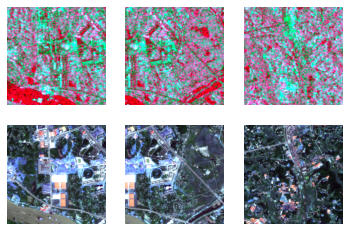

In [2]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [3]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [4]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [6]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [9]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [10]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [11]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot
 

In [ ]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (475, 256, 256, 3) (475, 256, 256, 3)
>1, d1[0.286] d2[1.026] g[56.760]
>2, d1[0.349] d2[0.728] g[44.874]
>3, d1[0.303] d2[0.600] g[43.688]
>4, d1[0.381] d2[0.519] g[75.767]
>5, d1[0.402] d2[0.471] g[46.170]
>6, d1[0.422] d2[0.457] g[59.253]
>7, d1[0.420] d2[0.519] g[33.154]
>8, d1[0.477] d2[0.421] g[43.802]
>9, d1[0.456] d2[0.431] g[37.955]
>10, d1[0.451] d2[0.431] g[43.926]
>11, d1[0.423] d2[0.391] g[43.010]
>12, d1[0.417] d2[0.449] g[57.183]
>13, d1[0.401] d2[0.430] g[43.385]
>14, d1[0.529] d2[0.420] g[43.133]
>15, d1[0.476] d2[0.476] g[38.294]
>16, d1[0.448] d2[0.444] g[33.676]
>17, d1[0.487] d2[0.428] g[52.932]
>18, d1[0.448] d2[0.416] g[34.197]
>19, d1[0.446] d2[0.437] g[35.643]
>20, d1[0.443] d2[0.468] g[35.609]
>21, d1[0.436] d2[0.428] g[38.555]
>22, d1[0.458] d2[0.419] g[35.831]
>23, d1[0.433] d2[0.465] g[34.161]
>24, d1[0.440] d2[0.416] g[36.080]
>25, d1[0.443] d2[0.438] g[34.889]
>26, d1[0.443] d2[0.403] g[34.733]
>27, d1[0.372] d2[0.452] g[47.805]
>28, d1[0.407] d2[0

>231, d1[0.166] d2[0.115] g[34.787]
>232, d1[0.063] d2[0.026] g[39.352]
>233, d1[0.131] d2[0.027] g[48.297]
>234, d1[0.071] d2[0.021] g[40.529]
>235, d1[0.017] d2[0.053] g[41.775]
>236, d1[0.045] d2[0.038] g[40.224]
>237, d1[0.631] d2[1.163] g[40.876]
>238, d1[0.063] d2[0.025] g[38.152]
>239, d1[0.158] d2[0.072] g[33.697]
>240, d1[0.109] d2[0.089] g[35.187]
>241, d1[0.059] d2[0.094] g[43.958]
>242, d1[0.543] d2[1.291] g[49.658]
>243, d1[0.149] d2[0.049] g[36.921]
>244, d1[0.103] d2[0.023] g[47.048]
>245, d1[0.024] d2[0.033] g[44.641]
>246, d1[0.094] d2[0.084] g[38.673]
>247, d1[0.124] d2[0.282] g[37.599]
>248, d1[0.029] d2[0.022] g[38.473]
>249, d1[0.038] d2[0.017] g[38.501]
>250, d1[0.338] d2[0.032] g[35.395]
>251, d1[0.005] d2[0.504] g[44.023]
>252, d1[0.364] d2[0.131] g[40.765]
>253, d1[0.012] d2[0.057] g[39.295]
>254, d1[0.031] d2[0.027] g[38.744]
>255, d1[0.021] d2[0.044] g[40.895]
>256, d1[0.041] d2[0.176] g[37.092]
>257, d1[0.046] d2[0.019] g[46.342]
>258, d1[0.030] d2[0.028] g[

>459, d1[0.109] d2[0.015] g[43.778]
>460, d1[0.026] d2[0.116] g[37.558]
>461, d1[0.003] d2[0.056] g[46.738]
>462, d1[0.014] d2[0.024] g[40.457]
>463, d1[0.091] d2[0.110] g[45.450]
>464, d1[0.033] d2[0.025] g[40.784]
>465, d1[0.194] d2[0.506] g[42.954]
>466, d1[0.015] d2[0.009] g[47.178]
>467, d1[0.484] d2[0.048] g[37.963]
>468, d1[0.014] d2[0.055] g[37.393]
>469, d1[0.002] d2[0.282] g[44.054]
>470, d1[0.219] d2[0.047] g[38.820]
>471, d1[1.026] d2[1.312] g[36.717]
>472, d1[0.021] d2[0.045] g[43.275]
>473, d1[0.066] d2[0.018] g[39.755]
>474, d1[0.017] d2[0.069] g[50.958]
>475, d1[0.215] d2[0.097] g[33.768]
>476, d1[0.008] d2[0.104] g[38.381]
>477, d1[0.537] d2[0.259] g[29.569]
>478, d1[0.004] d2[0.201] g[47.696]
>479, d1[0.034] d2[0.052] g[37.629]
>480, d1[0.023] d2[0.116] g[36.920]
>481, d1[0.051] d2[0.040] g[39.332]
>482, d1[0.179] d2[0.604] g[48.726]
>483, d1[0.958] d2[0.025] g[38.139]
>484, d1[0.081] d2[0.044] g[34.253]
>485, d1[0.010] d2[0.340] g[37.321]
>486, d1[0.024] d2[0.009] g[

>687, d1[0.022] d2[0.039] g[42.014]
>688, d1[0.019] d2[0.036] g[42.237]
>689, d1[0.072] d2[0.102] g[37.742]
>690, d1[0.084] d2[0.052] g[38.239]
>691, d1[0.010] d2[0.063] g[38.925]
>692, d1[0.025] d2[0.020] g[41.899]
>693, d1[0.211] d2[0.467] g[34.645]
>694, d1[1.079] d2[0.113] g[27.250]
>695, d1[0.141] d2[0.203] g[34.603]
>696, d1[0.006] d2[0.020] g[46.758]
>697, d1[0.070] d2[0.055] g[31.299]
>698, d1[0.073] d2[0.121] g[34.392]
>699, d1[0.209] d2[0.061] g[38.858]
>700, d1[0.043] d2[0.276] g[50.073]
>701, d1[0.025] d2[0.062] g[38.014]
>702, d1[0.051] d2[0.021] g[33.485]
>703, d1[0.065] d2[0.020] g[41.536]
>704, d1[0.020] d2[0.090] g[36.881]
>705, d1[0.023] d2[0.026] g[39.651]
>706, d1[0.363] d2[0.402] g[29.938]
>707, d1[0.009] d2[0.030] g[38.409]
>708, d1[0.009] d2[0.018] g[42.605]
>709, d1[0.398] d2[0.419] g[36.731]
>710, d1[0.011] d2[0.012] g[44.634]
>711, d1[0.221] d2[0.046] g[35.427]
>712, d1[0.004] d2[0.032] g[37.150]
>713, d1[0.004] d2[1.040] g[54.787]
>714, d1[1.226] d2[0.028] g[

>915, d1[0.059] d2[0.060] g[36.931]
>916, d1[0.102] d2[0.053] g[35.034]
>917, d1[0.045] d2[0.100] g[31.832]
>918, d1[0.011] d2[0.062] g[42.484]
>919, d1[0.206] d2[0.148] g[35.670]
>920, d1[0.002] d2[0.107] g[36.790]
>921, d1[0.002] d2[0.047] g[46.936]
>922, d1[0.015] d2[0.175] g[36.076]
>923, d1[0.371] d2[0.127] g[42.072]
>924, d1[0.006] d2[0.160] g[35.898]
>925, d1[0.019] d2[0.054] g[33.600]
>926, d1[0.060] d2[0.097] g[30.226]
>927, d1[0.249] d2[0.259] g[39.373]
>928, d1[0.048] d2[0.140] g[32.010]
>929, d1[0.174] d2[0.138] g[38.751]
>930, d1[0.051] d2[0.265] g[38.638]
>931, d1[0.255] d2[0.018] g[37.720]
>932, d1[0.668] d2[0.157] g[34.640]
>933, d1[0.007] d2[0.873] g[31.046]
>934, d1[0.891] d2[0.044] g[30.956]
>935, d1[0.010] d2[0.035] g[44.829]
>936, d1[0.406] d2[0.306] g[31.656]
>937, d1[0.068] d2[0.098] g[30.888]
>938, d1[0.027] d2[0.110] g[35.265]
>939, d1[0.063] d2[0.152] g[31.709]
>940, d1[0.027] d2[0.084] g[34.300]
>941, d1[0.103] d2[0.052] g[33.453]
>942, d1[0.014] d2[0.074] g[

>1139, d1[0.027] d2[0.055] g[31.104]
>1140, d1[0.001] d2[0.208] g[36.204]
>1141, d1[0.087] d2[0.020] g[32.434]
>1142, d1[0.190] d2[0.193] g[37.121]
>1143, d1[0.002] d2[0.047] g[34.663]
>1144, d1[0.086] d2[0.108] g[36.266]
>1145, d1[0.011] d2[0.022] g[37.818]
>1146, d1[0.009] d2[0.028] g[31.922]
>1147, d1[0.126] d2[0.232] g[36.317]
>1148, d1[0.440] d2[1.575] g[40.954]
>1149, d1[1.146] d2[0.069] g[34.050]
>1150, d1[0.838] d2[0.302] g[27.699]
>1151, d1[0.018] d2[0.272] g[31.574]
>1152, d1[0.078] d2[0.158] g[35.186]
>1153, d1[0.060] d2[0.031] g[29.454]
>1154, d1[0.006] d2[0.045] g[38.070]
>1155, d1[0.285] d2[0.251] g[28.741]
>1156, d1[0.026] d2[0.037] g[35.758]
>1157, d1[0.047] d2[0.052] g[30.436]
>1158, d1[0.441] d2[0.743] g[27.633]
>1159, d1[0.238] d2[0.392] g[32.328]
>1160, d1[0.010] d2[0.020] g[40.746]
>1161, d1[0.527] d2[0.080] g[34.144]
>1162, d1[0.002] d2[0.550] g[36.699]
>1163, d1[0.421] d2[0.289] g[26.535]
>1164, d1[0.038] d2[0.048] g[33.761]
>1165, d1[0.386] d2[0.108] g[27.794]
>

>1361, d1[0.147] d2[0.024] g[33.808]
>1362, d1[0.023] d2[0.026] g[33.479]
>1363, d1[0.417] d2[0.188] g[28.439]
>1364, d1[0.009] d2[0.090] g[27.324]
>1365, d1[0.023] d2[0.051] g[30.590]
>1366, d1[0.004] d2[0.047] g[37.372]
>1367, d1[0.051] d2[0.078] g[31.261]
>1368, d1[0.066] d2[0.448] g[36.042]
>1369, d1[1.466] d2[0.042] g[23.839]
>1370, d1[0.269] d2[0.053] g[38.902]
>1371, d1[0.003] d2[0.088] g[32.234]
>1372, d1[0.118] d2[0.088] g[30.929]
>1373, d1[0.004] d2[0.146] g[31.270]
>1374, d1[0.013] d2[0.103] g[35.767]
>1375, d1[0.211] d2[0.081] g[27.445]
>1376, d1[0.004] d2[0.214] g[31.972]
>1377, d1[0.003] d2[0.025] g[39.985]
>1378, d1[0.067] d2[0.038] g[32.845]
>1379, d1[0.081] d2[0.029] g[31.557]
>1380, d1[0.028] d2[0.227] g[34.011]
>1381, d1[0.417] d2[0.156] g[26.906]
>1382, d1[0.023] d2[0.216] g[30.166]
>1383, d1[0.016] d2[0.027] g[35.281]
>1384, d1[0.879] d2[0.596] g[33.235]
>1385, d1[0.014] d2[0.044] g[32.856]
>1386, d1[0.413] d2[0.344] g[36.169]
>1387, d1[0.133] d2[0.045] g[35.782]
>

>1583, d1[0.003] d2[0.122] g[24.465]
>1584, d1[0.013] d2[0.224] g[27.991]
>1585, d1[0.258] d2[0.047] g[33.465]
>1586, d1[0.009] d2[0.525] g[31.980]
>1587, d1[0.095] d2[0.022] g[39.248]
>1588, d1[0.750] d2[0.445] g[31.279]
>1589, d1[1.207] d2[0.064] g[28.336]
>1590, d1[0.061] d2[0.243] g[28.590]
>1591, d1[0.030] d2[0.106] g[28.621]
>1592, d1[0.001] d2[0.089] g[41.799]
>1593, d1[0.012] d2[0.055] g[32.963]
>1594, d1[0.150] d2[0.118] g[26.330]
>1595, d1[0.079] d2[0.547] g[30.811]
>1596, d1[0.199] d2[0.018] g[37.608]
>1597, d1[0.125] d2[0.024] g[39.105]
>1598, d1[0.055] d2[0.060] g[26.660]
>1599, d1[0.341] d2[0.900] g[24.419]
>1600, d1[1.195] d2[0.075] g[32.771]
>1601, d1[0.103] d2[0.142] g[26.974]
>1602, d1[0.004] d2[0.116] g[31.305]
>1603, d1[0.429] d2[0.293] g[26.622]
>1604, d1[0.001] d2[0.734] g[36.252]
>1605, d1[0.126] d2[0.018] g[34.887]
>1606, d1[0.964] d2[0.045] g[34.868]
>1607, d1[0.050] d2[0.237] g[30.621]
>1608, d1[0.004] d2[0.049] g[33.573]
>1609, d1[0.077] d2[0.034] g[30.719]
>

>1805, d1[0.020] d2[0.056] g[33.095]
>1806, d1[0.166] d2[0.107] g[32.652]
>1807, d1[0.030] d2[0.059] g[27.443]
>1808, d1[0.129] d2[0.313] g[23.069]
>1809, d1[0.017] d2[0.045] g[31.814]
>1810, d1[0.013] d2[0.060] g[30.777]
>1811, d1[0.338] d2[0.499] g[24.249]
>1812, d1[0.830] d2[0.062] g[27.334]
>1813, d1[0.003] d2[0.089] g[31.967]
>1814, d1[0.058] d2[0.134] g[28.187]
>1815, d1[0.012] d2[0.089] g[28.919]
>1816, d1[0.064] d2[0.124] g[26.330]
>1817, d1[0.020] d2[0.037] g[34.459]
>1818, d1[0.004] d2[0.084] g[32.067]
>1819, d1[0.005] d2[0.038] g[31.571]
>1820, d1[0.149] d2[0.125] g[28.609]
>1821, d1[0.033] d2[0.255] g[25.532]
>1822, d1[0.279] d2[0.719] g[35.529]
>1823, d1[0.912] d2[0.100] g[22.603]
>1824, d1[0.190] d2[0.109] g[30.958]
>1825, d1[0.049] d2[0.132] g[26.992]
>1826, d1[0.015] d2[0.063] g[32.870]
>1827, d1[0.114] d2[0.173] g[27.556]
>1828, d1[0.023] d2[0.146] g[33.741]
>1829, d1[0.059] d2[0.059] g[23.027]
>1830, d1[0.150] d2[0.469] g[29.267]
>1831, d1[0.520] d2[0.057] g[23.390]
>

>2027, d1[1.064] d2[0.081] g[25.030]
>2028, d1[0.085] d2[0.117] g[29.072]
>2029, d1[0.745] d2[0.260] g[27.757]
>2030, d1[0.214] d2[0.377] g[23.501]
>2031, d1[0.131] d2[0.171] g[24.126]
>2032, d1[0.004] d2[0.160] g[27.712]
>2033, d1[0.064] d2[0.054] g[22.253]
>2034, d1[0.016] d2[0.103] g[25.616]
>2035, d1[0.091] d2[0.086] g[24.244]
>2036, d1[0.005] d2[0.066] g[29.562]
>2037, d1[0.050] d2[0.059] g[23.738]
>2038, d1[0.002] d2[0.038] g[30.680]
>2039, d1[0.007] d2[0.053] g[28.733]
>2040, d1[0.003] d2[0.037] g[30.498]
>2041, d1[0.175] d2[0.304] g[21.778]
>2042, d1[0.009] d2[0.031] g[27.450]
>2043, d1[0.707] d2[0.128] g[35.894]
>2044, d1[0.002] d2[0.357] g[34.882]
>2045, d1[0.332] d2[0.194] g[25.796]
>2046, d1[0.078] d2[0.360] g[22.851]
>2047, d1[0.014] d2[0.024] g[30.695]
>2048, d1[0.034] d2[0.027] g[45.933]
>2049, d1[0.079] d2[0.047] g[27.494]
>2050, d1[0.003] d2[0.029] g[37.230]
>2051, d1[0.029] d2[0.025] g[29.173]
>2052, d1[0.622] d2[0.133] g[24.627]
>2053, d1[0.002] d2[0.057] g[29.470]
>

>2249, d1[0.324] d2[1.212] g[25.051]
>2250, d1[0.004] d2[0.134] g[27.149]
>2251, d1[0.035] d2[0.024] g[31.610]
>2252, d1[0.144] d2[0.097] g[21.968]
>2253, d1[0.011] d2[0.159] g[25.796]
>2254, d1[0.008] d2[0.064] g[28.625]
>2255, d1[0.117] d2[0.021] g[25.923]
>2256, d1[0.329] d2[1.384] g[22.868]
>2257, d1[0.042] d2[0.039] g[25.807]
>2258, d1[1.461] d2[0.054] g[23.181]
>2259, d1[0.006] d2[0.984] g[27.824]
>2260, d1[0.157] d2[0.023] g[27.146]
>2261, d1[0.150] d2[0.040] g[26.128]
>2262, d1[0.037] d2[0.027] g[29.501]
>2263, d1[0.014] d2[0.032] g[29.289]
>2264, d1[0.030] d2[0.019] g[29.592]
>2265, d1[0.265] d2[0.619] g[24.497]
>2266, d1[0.972] d2[0.100] g[20.218]
>2267, d1[0.152] d2[0.142] g[21.203]
>2268, d1[0.046] d2[0.191] g[26.766]
>2269, d1[0.088] d2[0.082] g[26.327]
>2270, d1[0.054] d2[0.031] g[25.586]
>2271, d1[0.007] d2[0.034] g[30.989]
>2272, d1[0.669] d2[0.258] g[22.894]
>2273, d1[0.027] d2[0.380] g[23.000]
>2274, d1[0.035] d2[0.484] g[25.028]
>2275, d1[0.504] d2[0.071] g[21.347]
>

>2471, d1[0.332] d2[0.267] g[25.666]
>2472, d1[0.007] d2[0.042] g[28.878]
>2473, d1[0.012] d2[0.108] g[23.974]
>2474, d1[0.587] d2[0.408] g[18.539]
>2475, d1[0.214] d2[0.061] g[29.228]
>2476, d1[0.056] d2[0.495] g[26.377]
>2477, d1[0.009] d2[0.036] g[30.815]
>2478, d1[0.494] d2[0.154] g[23.105]
>2479, d1[0.009] d2[0.041] g[27.094]
>2480, d1[0.015] d2[1.301] g[22.911]
>2481, d1[0.058] d2[0.016] g[32.790]
>2482, d1[1.301] d2[0.086] g[22.971]
>2483, d1[1.135] d2[0.199] g[20.762]
>2484, d1[0.026] d2[0.300] g[27.247]
>2485, d1[0.213] d2[0.170] g[23.551]
>2486, d1[0.165] d2[0.211] g[20.988]
>2487, d1[0.007] d2[0.158] g[29.983]
>2488, d1[0.381] d2[0.078] g[23.341]
>2489, d1[0.027] d2[0.372] g[21.192]
>2490, d1[0.785] d2[0.152] g[24.615]
>2491, d1[0.050] d2[0.272] g[23.264]
>2492, d1[0.016] d2[0.045] g[25.702]
>2493, d1[0.457] d2[0.298] g[21.364]
>2494, d1[0.004] d2[0.061] g[34.906]
>2495, d1[0.012] d2[0.096] g[25.862]
>2496, d1[0.044] d2[0.055] g[26.750]
>2497, d1[0.242] d2[0.169] g[20.003]
>

>2693, d1[0.374] d2[1.794] g[23.478]
>2694, d1[0.081] d2[0.107] g[27.905]
>2695, d1[0.184] d2[0.247] g[26.286]
>2696, d1[0.688] d2[0.147] g[26.942]
>2697, d1[0.100] d2[0.542] g[24.512]
>2698, d1[0.056] d2[0.025] g[27.957]
>2699, d1[0.066] d2[0.080] g[27.399]
>2700, d1[0.724] d2[0.831] g[20.802]
>2701, d1[0.046] d2[0.032] g[27.108]
>2702, d1[0.055] d2[0.046] g[27.983]
>2703, d1[0.415] d2[0.441] g[22.982]
>2704, d1[0.178] d2[0.427] g[22.642]
>2705, d1[0.043] d2[0.030] g[31.444]
>2706, d1[0.086] d2[0.043] g[26.772]
>2707, d1[0.048] d2[0.049] g[23.942]
>2708, d1[0.042] d2[0.047] g[26.474]
>2709, d1[0.128] d2[0.161] g[23.566]
>2710, d1[0.259] d2[0.457] g[26.398]
>2711, d1[0.089] d2[0.078] g[25.513]
>2712, d1[0.991] d2[0.217] g[25.470]
>2713, d1[0.008] d2[0.273] g[24.025]
>2714, d1[0.337] d2[0.113] g[20.682]
>2715, d1[0.058] d2[0.938] g[20.432]
>2716, d1[0.016] d2[0.026] g[35.658]
>2717, d1[0.398] d2[0.036] g[26.509]
>2718, d1[0.293] d2[0.160] g[20.939]
>2719, d1[0.205] d2[0.370] g[23.513]
>

>2915, d1[0.028] d2[0.325] g[20.441]
>2916, d1[0.450] d2[0.139] g[20.123]
>2917, d1[0.121] d2[0.249] g[19.472]
>2918, d1[0.018] d2[0.024] g[24.799]
>2919, d1[0.159] d2[0.081] g[21.848]
>2920, d1[0.008] d2[0.030] g[25.101]
>2921, d1[0.015] d2[0.075] g[24.113]
>2922, d1[0.207] d2[0.283] g[19.186]
>2923, d1[0.020] d2[0.032] g[26.021]
>2924, d1[0.029] d2[0.034] g[21.604]
>2925, d1[0.020] d2[0.037] g[25.118]
>2926, d1[0.021] d2[0.028] g[25.596]
>2927, d1[0.014] d2[0.030] g[26.155]
>2928, d1[0.116] d2[0.050] g[22.653]
>2929, d1[0.019] d2[0.271] g[24.014]
>2930, d1[0.010] d2[0.022] g[31.800]
>2931, d1[0.079] d2[0.029] g[23.834]
>2932, d1[0.747] d2[0.454] g[19.948]
>2933, d1[0.209] d2[0.096] g[18.450]
>2934, d1[0.023] d2[0.176] g[22.707]
>2935, d1[0.019] d2[0.050] g[22.473]
>2936, d1[0.035] d2[0.027] g[24.936]
>2937, d1[0.123] d2[0.166] g[23.174]
>2938, d1[0.075] d2[0.102] g[23.604]
>2939, d1[0.014] d2[0.060] g[30.328]
>2940, d1[0.329] d2[1.297] g[23.830]
>2941, d1[0.820] d2[0.321] g[19.807]
>

>3137, d1[0.047] d2[0.029] g[29.363]
>3138, d1[0.050] d2[0.071] g[22.738]
>3139, d1[0.457] d2[0.666] g[25.513]
>3140, d1[0.048] d2[0.041] g[25.654]
>3141, d1[0.141] d2[0.032] g[23.877]
>3142, d1[0.165] d2[0.213] g[21.997]
>3143, d1[0.028] d2[0.044] g[25.537]
>3144, d1[0.038] d2[0.037] g[27.719]
>3145, d1[0.018] d2[0.031] g[27.152]
>3146, d1[0.040] d2[0.050] g[28.855]
>3147, d1[0.241] d2[0.199] g[16.534]
>3148, d1[0.008] d2[0.119] g[30.587]
>3149, d1[0.369] d2[0.504] g[17.571]
>3150, d1[0.210] d2[0.079] g[22.096]
>3151, d1[0.033] d2[0.166] g[23.316]
>3152, d1[0.027] d2[0.030] g[25.448]
>3153, d1[0.140] d2[0.053] g[22.552]
>3154, d1[0.010] d2[0.069] g[33.326]
>3155, d1[0.229] d2[0.645] g[21.978]
>3156, d1[0.050] d2[0.038] g[24.432]
>3157, d1[0.240] d2[0.170] g[24.293]
>3158, d1[0.109] d2[0.158] g[22.373]
>3159, d1[0.030] d2[0.032] g[24.364]
>3160, d1[0.091] d2[0.121] g[22.240]
>3161, d1[0.062] d2[0.144] g[22.192]
>3162, d1[0.606] d2[0.498] g[18.482]
>3163, d1[0.035] d2[0.027] g[27.743]
>

>3359, d1[0.017] d2[0.215] g[23.370]
>3360, d1[0.094] d2[0.031] g[26.134]
>3361, d1[0.480] d2[0.826] g[16.930]
>3362, d1[0.274] d2[0.115] g[19.933]
>3363, d1[0.046] d2[0.081] g[23.679]
>3364, d1[0.029] d2[0.093] g[19.993]
>3365, d1[0.024] d2[0.137] g[23.834]
>3366, d1[0.043] d2[0.025] g[23.719]
>3367, d1[0.023] d2[0.058] g[26.823]
>3368, d1[0.022] d2[0.042] g[27.792]
>3369, d1[0.055] d2[0.029] g[24.991]
>3370, d1[0.037] d2[0.050] g[23.039]
>3371, d1[0.189] d2[0.461] g[19.610]
>3372, d1[0.116] d2[0.037] g[23.983]
>3373, d1[0.087] d2[0.072] g[23.217]
>3374, d1[0.190] d2[0.532] g[23.308]
>3375, d1[0.870] d2[0.165] g[23.910]
>3376, d1[0.095] d2[0.064] g[25.221]
>3377, d1[0.466] d2[1.031] g[18.104]
>3378, d1[0.061] d2[0.077] g[25.904]
>3379, d1[0.115] d2[0.067] g[25.209]
>3380, d1[0.168] d2[0.178] g[21.968]
>3381, d1[0.027] d2[0.080] g[26.496]
>3382, d1[0.027] d2[0.076] g[24.973]
>3383, d1[0.048] d2[0.056] g[22.861]
>3384, d1[0.463] d2[0.201] g[14.944]
>3385, d1[0.022] d2[0.404] g[24.787]
>

>3581, d1[0.095] d2[0.068] g[22.099]
>3582, d1[0.608] d2[0.231] g[15.558]
>3583, d1[0.025] d2[0.237] g[22.362]
>3584, d1[0.150] d2[0.065] g[23.253]
>3585, d1[0.025] d2[0.058] g[23.454]
>3586, d1[0.114] d2[0.167] g[19.126]
>3587, d1[0.061] d2[0.101] g[23.144]
>3588, d1[0.062] d2[0.135] g[22.391]
>3589, d1[0.296] d2[0.249] g[16.585]
>3590, d1[0.254] d2[0.148] g[24.021]
>3591, d1[0.022] d2[0.049] g[25.806]
>3592, d1[0.033] d2[0.277] g[20.257]
>3593, d1[0.100] d2[0.041] g[24.559]
>3594, d1[0.157] d2[0.070] g[23.581]
>3595, d1[0.087] d2[0.122] g[20.410]
>3596, d1[0.071] d2[0.129] g[21.050]
>3597, d1[0.299] d2[0.870] g[19.062]
>3598, d1[0.259] d2[0.085] g[20.639]
>3599, d1[0.298] d2[0.293] g[23.316]
>3600, d1[0.015] d2[0.385] g[25.338]
>3601, d1[0.811] d2[0.102] g[18.155]
>3602, d1[0.324] d2[0.740] g[17.401]
>3603, d1[0.261] d2[0.127] g[19.434]
>3604, d1[0.057] d2[0.137] g[23.816]
>3605, d1[0.077] d2[0.088] g[23.512]
>3606, d1[0.437] d2[0.708] g[19.227]
>3607, d1[0.321] d2[0.189] g[19.016]
>

>3803, d1[0.146] d2[0.337] g[22.446]
>3804, d1[0.121] d2[0.128] g[19.656]
>3805, d1[0.175] d2[0.078] g[26.796]
>3806, d1[0.114] d2[0.323] g[18.444]
>3807, d1[0.734] d2[0.295] g[23.067]
>3808, d1[0.074] d2[0.217] g[17.860]
>3809, d1[0.055] d2[0.082] g[20.686]
>3810, d1[0.249] d2[0.407] g[19.148]
>3811, d1[0.909] d2[0.078] g[16.984]
>3812, d1[0.034] d2[0.077] g[25.043]
>3813, d1[0.077] d2[0.322] g[15.966]
>3814, d1[0.140] d2[0.113] g[21.728]
>3815, d1[0.224] d2[0.218] g[15.546]
>3816, d1[0.031] d2[0.069] g[22.963]
>3817, d1[0.038] d2[0.128] g[23.307]
>3818, d1[0.041] d2[0.053] g[23.682]
>3819, d1[0.093] d2[0.143] g[22.204]
>3820, d1[0.388] d2[0.521] g[19.062]
>3821, d1[0.125] d2[0.197] g[21.199]
>3822, d1[0.215] d2[0.286] g[18.544]
>3823, d1[0.606] d2[0.505] g[20.578]
>3824, d1[0.450] d2[0.158] g[17.112]
>3825, d1[0.062] d2[0.092] g[20.740]
>3826, d1[0.075] d2[0.399] g[18.685]
>3827, d1[0.033] d2[0.058] g[24.351]
>3828, d1[0.789] d2[0.229] g[15.763]
>3829, d1[0.060] d2[0.125] g[24.097]
>

>4025, d1[0.030] d2[0.094] g[21.150]
>4026, d1[0.220] d2[0.265] g[16.828]
>4027, d1[0.271] d2[0.199] g[19.895]
>4028, d1[0.184] d2[0.291] g[20.591]
>4029, d1[0.240] d2[0.320] g[19.861]
>4030, d1[0.153] d2[0.112] g[18.681]
>4031, d1[0.054] d2[0.224] g[21.217]
>4032, d1[0.196] d2[0.067] g[21.794]
>4033, d1[0.022] d2[0.059] g[24.805]
>4034, d1[0.193] d2[0.474] g[20.145]
>4035, d1[0.207] d2[0.073] g[20.989]
>4036, d1[0.105] d2[0.071] g[21.408]
>4037, d1[0.077] d2[0.441] g[19.930]
>4038, d1[0.197] d2[0.134] g[20.243]
>4039, d1[0.528] d2[0.228] g[15.955]
>4040, d1[0.041] d2[0.107] g[21.900]
>4041, d1[0.029] d2[0.065] g[24.254]
>4042, d1[0.444] d2[0.323] g[16.585]
>4043, d1[0.018] d2[0.199] g[21.747]
>4044, d1[0.156] d2[0.109] g[21.839]
>4045, d1[0.186] d2[0.337] g[20.691]
>4046, d1[0.035] d2[0.044] g[26.818]
>4047, d1[0.459] d2[0.158] g[20.631]
>4048, d1[0.349] d2[0.590] g[19.097]
>4049, d1[0.069] d2[0.256] g[16.240]
>4050, d1[0.039] d2[0.045] g[22.479]
>4051, d1[0.675] d2[0.277] g[17.666]
>

>4247, d1[0.110] d2[0.245] g[18.514]
>4248, d1[0.509] d2[0.201] g[17.506]
>4249, d1[0.054] d2[0.211] g[17.542]
>4250, d1[0.041] d2[0.081] g[20.666]
>4251, d1[0.090] d2[0.107] g[22.461]
>4252, d1[0.032] d2[0.051] g[22.362]
>4253, d1[0.172] d2[0.256] g[15.393]
>4254, d1[0.202] d2[0.211] g[15.818]
>4255, d1[0.152] d2[0.198] g[16.614]
>4256, d1[0.167] d2[0.290] g[19.202]
>4257, d1[0.020] d2[0.048] g[24.401]
>4258, d1[0.815] d2[0.191] g[19.821]
>4259, d1[0.031] d2[0.084] g[22.721]
>4260, d1[0.034] d2[0.195] g[19.910]
>4261, d1[0.296] d2[0.342] g[17.956]
>4262, d1[0.273] d2[0.297] g[16.200]
>4263, d1[0.082] d2[0.058] g[21.118]
>4264, d1[0.173] d2[0.289] g[15.796]
>4265, d1[0.129] d2[0.098] g[18.836]
>4266, d1[0.039] d2[0.105] g[20.062]
>4267, d1[0.206] d2[0.291] g[17.049]
>4268, d1[0.025] d2[0.050] g[22.274]
>4269, d1[0.036] d2[0.054] g[22.798]
>4270, d1[0.082] d2[0.070] g[21.637]
>4271, d1[0.034] d2[0.108] g[22.329]
>4272, d1[0.088] d2[0.076] g[21.373]
>4273, d1[0.041] d2[0.132] g[22.078]
>

>4469, d1[0.802] d2[0.210] g[14.752]
>4470, d1[0.103] d2[0.067] g[19.459]
>4471, d1[0.193] d2[0.505] g[17.502]
>4472, d1[0.274] d2[0.173] g[17.821]
>4473, d1[0.296] d2[0.524] g[15.378]
>4474, d1[0.037] d2[0.049] g[20.056]
>4475, d1[0.409] d2[0.244] g[16.231]
>4476, d1[0.310] d2[0.198] g[16.614]
>4477, d1[0.035] d2[0.139] g[18.175]
>4478, d1[0.192] d2[0.293] g[16.256]
>4479, d1[0.023] d2[0.096] g[20.728]
>4480, d1[0.522] d2[0.362] g[13.842]
>4481, d1[0.073] d2[0.086] g[19.239]
>4482, d1[0.155] d2[0.510] g[15.013]
>4483, d1[0.128] d2[0.056] g[21.670]
>4484, d1[0.208] d2[0.097] g[20.076]
>4485, d1[0.024] d2[0.356] g[22.009]
>4486, d1[0.115] d2[0.042] g[22.839]
>4487, d1[0.920] d2[0.173] g[13.851]
>4488, d1[0.546] d2[0.352] g[14.405]
>4489, d1[0.180] d2[0.354] g[15.397]
>4490, d1[0.175] d2[0.276] g[19.722]
>4491, d1[0.018] d2[0.069] g[19.007]
>4492, d1[0.104] d2[0.157] g[19.867]
>4493, d1[0.237] d2[0.258] g[16.953]
>4494, d1[0.041] d2[0.059] g[21.473]
>4495, d1[0.041] d2[0.064] g[19.635]
>

>4691, d1[0.044] d2[0.116] g[20.298]
>4692, d1[0.038] d2[0.098] g[18.879]
>4693, d1[0.061] d2[0.110] g[21.305]
>4694, d1[0.287] d2[0.529] g[18.153]
>4695, d1[0.309] d2[0.077] g[19.400]
>4696, d1[0.290] d2[0.375] g[15.453]
>4697, d1[0.022] d2[0.108] g[20.681]
>4698, d1[0.164] d2[0.130] g[18.787]
>4699, d1[0.370] d2[0.474] g[16.717]
>4700, d1[0.018] d2[0.076] g[22.392]
>4701, d1[0.232] d2[0.158] g[19.096]
>4702, d1[0.036] d2[0.128] g[20.281]
>4703, d1[0.215] d2[0.411] g[17.809]
>4704, d1[1.044] d2[0.073] g[19.026]
>4705, d1[0.107] d2[0.318] g[18.505]
>4706, d1[0.234] d2[0.088] g[21.737]
>4707, d1[0.030] d2[0.225] g[20.043]
>4708, d1[0.169] d2[0.182] g[19.772]
>4709, d1[0.088] d2[0.106] g[19.581]
>4710, d1[0.051] d2[0.071] g[20.272]
>4711, d1[0.060] d2[0.201] g[17.742]
>4712, d1[0.595] d2[0.224] g[14.074]
>4713, d1[0.100] d2[0.103] g[18.611]
>4714, d1[0.016] d2[0.200] g[19.557]
>4715, d1[0.450] d2[0.285] g[16.629]
>4716, d1[0.266] d2[0.371] g[15.854]
>4717, d1[0.165] d2[0.073] g[19.696]
>

>4912, d1[0.041] d2[0.056] g[20.281]
>4913, d1[0.565] d2[0.163] g[14.944]
>4914, d1[0.087] d2[0.170] g[16.858]
>4915, d1[0.592] d2[0.935] g[14.349]
>4916, d1[0.277] d2[0.234] g[16.209]
>4917, d1[0.035] d2[0.233] g[19.109]
>4918, d1[0.211] d2[0.094] g[19.971]
>4919, d1[0.150] d2[0.228] g[18.130]
>4920, d1[0.102] d2[0.079] g[20.401]
>4921, d1[0.032] d2[0.075] g[19.164]
>4922, d1[0.247] d2[0.285] g[18.368]
>4923, d1[0.043] d2[0.144] g[19.718]
>4924, d1[0.628] d2[0.244] g[13.511]
>4925, d1[0.017] d2[0.082] g[20.985]
>4926, d1[0.062] d2[0.280] g[21.467]
>4927, d1[0.187] d2[0.090] g[18.649]
>4928, d1[0.778] d2[0.156] g[17.740]
>4929, d1[0.105] d2[0.500] g[16.212]
>4930, d1[0.169] d2[0.183] g[18.134]
>4931, d1[0.351] d2[0.324] g[16.033]
>4932, d1[0.017] d2[0.076] g[21.643]
>4933, d1[0.588] d2[0.228] g[15.423]
>4934, d1[0.310] d2[0.449] g[14.848]
>4935, d1[0.170] d2[0.558] g[16.843]
>4936, d1[0.332] d2[0.138] g[18.054]
>4937, d1[0.027] d2[0.158] g[20.546]
>4938, d1[0.236] d2[0.222] g[17.735]
>

>5134, d1[0.024] d2[0.039] g[22.383]
>5135, d1[0.903] d2[0.111] g[17.645]
>5136, d1[0.397] d2[0.437] g[14.432]
>5137, d1[0.249] d2[0.249] g[15.498]
>5138, d1[0.067] d2[0.115] g[17.213]
>5139, d1[0.444] d2[0.305] g[16.620]
>5140, d1[0.153] d2[0.378] g[15.791]
>5141, d1[0.034] d2[0.080] g[20.909]
>5142, d1[0.264] d2[0.282] g[17.803]
>5143, d1[0.073] d2[0.135] g[17.927]
>5144, d1[0.030] d2[0.066] g[20.759]
>5145, d1[0.462] d2[0.285] g[15.138]
>5146, d1[0.070] d2[0.385] g[14.616]
>5147, d1[0.459] d2[0.322] g[14.406]
>5148, d1[0.026] d2[0.102] g[20.945]
>5149, d1[0.028] d2[0.045] g[20.093]
>5150, d1[0.171] d2[0.155] g[17.342]
>5151, d1[0.533] d2[0.543] g[17.205]
>5152, d1[0.155] d2[0.212] g[16.002]
>5153, d1[0.381] d2[0.246] g[13.569]
>5154, d1[0.265] d2[0.295] g[17.240]
>5155, d1[0.111] d2[0.168] g[18.282]
>5156, d1[0.035] d2[0.107] g[20.337]
>5157, d1[0.170] d2[0.226] g[19.267]
>5158, d1[0.045] d2[0.057] g[17.832]
>5159, d1[0.073] d2[0.068] g[19.688]
>5160, d1[0.451] d2[0.472] g[17.077]
>

>5356, d1[0.349] d2[0.301] g[16.950]
>5357, d1[0.673] d2[0.223] g[13.297]
>5358, d1[0.345] d2[0.618] g[13.279]
>5359, d1[0.029] d2[0.067] g[20.337]
>5360, d1[0.535] d2[0.294] g[16.763]
>5361, d1[0.027] d2[0.145] g[20.100]
>5362, d1[0.021] d2[0.074] g[19.089]
>5363, d1[0.392] d2[0.576] g[17.817]
>5364, d1[0.072] d2[0.098] g[19.679]
>5365, d1[0.225] d2[0.072] g[19.862]
>5366, d1[0.657] d2[0.322] g[11.862]
>5367, d1[0.021] d2[0.370] g[16.956]
>5368, d1[0.071] d2[0.052] g[17.927]
>5369, d1[0.339] d2[0.293] g[17.830]
>5370, d1[0.426] d2[0.154] g[17.879]
>5371, d1[0.022] d2[0.554] g[19.042]
>5372, d1[0.604] d2[0.162] g[15.221]
>5373, d1[0.432] d2[0.243] g[20.865]
>5374, d1[0.029] d2[0.069] g[23.055]
>5375, d1[0.262] d2[0.410] g[12.497]
>5376, d1[0.169] d2[0.334] g[14.823]
>5377, d1[0.259] d2[0.098] g[17.429]
>5378, d1[0.085] d2[0.349] g[20.123]
>5379, d1[0.818] d2[0.146] g[14.254]
>5380, d1[0.031] d2[0.142] g[19.881]
>5381, d1[0.070] d2[0.146] g[19.521]
>5382, d1[0.095] d2[0.191] g[16.288]
>

>5578, d1[0.057] d2[0.173] g[17.490]
>5579, d1[0.195] d2[0.224] g[18.365]
>5580, d1[0.043] d2[0.147] g[19.633]
>5581, d1[0.071] d2[0.086] g[18.152]
>5582, d1[0.536] d2[0.245] g[14.709]
>5583, d1[0.027] d2[0.058] g[18.482]
>5584, d1[0.527] d2[0.417] g[13.141]
>5585, d1[0.016] d2[0.187] g[19.874]
>5586, d1[0.252] d2[0.129] g[16.807]
>5587, d1[0.061] d2[0.290] g[17.161]
>5588, d1[0.260] d2[0.199] g[16.036]
>5589, d1[0.117] d2[0.206] g[16.280]
>5590, d1[0.166] d2[0.173] g[20.842]
>5591, d1[0.015] d2[0.090] g[20.263]
>5592, d1[0.741] d2[0.171] g[12.369]
>5593, d1[0.046] d2[0.464] g[17.870]
>5594, d1[0.459] d2[0.220] g[13.687]
>5595, d1[0.554] d2[0.258] g[17.002]
>5596, d1[0.029] d2[0.113] g[17.871]
>5597, d1[0.063] d2[0.508] g[13.554]
>5598, d1[0.088] d2[0.070] g[19.287]
>5599, d1[0.361] d2[0.315] g[19.091]
>5600, d1[0.015] d2[0.060] g[23.644]
>5601, d1[0.024] d2[0.057] g[22.639]
>5602, d1[0.065] d2[0.066] g[20.734]
>5603, d1[0.093] d2[0.167] g[17.931]
>5604, d1[0.028] d2[0.073] g[20.944]
>

>5800, d1[0.185] d2[0.275] g[13.023]
>5801, d1[0.397] d2[0.252] g[14.511]
>5802, d1[0.038] d2[0.265] g[18.940]
>5803, d1[0.062] d2[0.053] g[20.474]
>5804, d1[0.030] d2[0.050] g[22.404]
>5805, d1[0.733] d2[0.200] g[12.443]
>5806, d1[0.475] d2[0.296] g[15.409]
>5807, d1[0.040] d2[0.208] g[20.505]
>5808, d1[0.184] d2[0.249] g[16.678]
>5809, d1[0.318] d2[0.246] g[20.541]
>5810, d1[0.070] d2[0.286] g[20.493]
>5811, d1[0.096] d2[0.115] g[18.308]
>5812, d1[0.139] d2[0.075] g[21.432]
>5813, d1[0.090] d2[0.172] g[16.942]
>5814, d1[0.047] d2[0.089] g[18.878]
>5815, d1[0.020] d2[0.089] g[19.031]
>5816, d1[0.091] d2[0.168] g[17.981]
>5817, d1[0.060] d2[0.220] g[18.607]
>5818, d1[0.362] d2[0.219] g[18.499]
>5819, d1[0.040] d2[0.068] g[18.539]
>5820, d1[0.020] d2[0.050] g[20.819]
>5821, d1[0.645] d2[0.557] g[17.700]
>5822, d1[0.140] d2[0.512] g[17.153]
>5823, d1[0.326] d2[0.207] g[18.871]
>5824, d1[0.758] d2[0.301] g[14.485]
>5825, d1[0.361] d2[0.300] g[14.268]
>5826, d1[0.320] d2[0.280] g[16.897]
>

>6022, d1[0.610] d2[0.380] g[14.118]
>6023, d1[0.199] d2[0.265] g[18.131]
>6024, d1[0.105] d2[0.171] g[15.947]
>6025, d1[0.074] d2[0.083] g[18.105]
>6026, d1[0.232] d2[0.310] g[17.278]
>6027, d1[0.075] d2[0.090] g[15.406]
>6028, d1[0.707] d2[0.281] g[13.992]
>6029, d1[0.024] d2[0.304] g[18.360]
>6030, d1[0.341] d2[0.284] g[13.906]
>6031, d1[0.214] d2[0.186] g[17.307]
>6032, d1[0.015] d2[0.057] g[20.431]
>6033, d1[0.075] d2[0.220] g[17.632]
>6034, d1[0.608] d2[0.283] g[15.516]
>6035, d1[0.147] d2[0.381] g[16.307]
>6036, d1[0.733] d2[0.155] g[14.487]
>6037, d1[0.074] d2[0.111] g[16.919]
>6038, d1[0.047] d2[0.191] g[16.258]
>6039, d1[0.090] d2[0.226] g[16.879]
>6040, d1[0.090] d2[0.065] g[19.152]
>6041, d1[0.083] d2[0.162] g[16.637]
>6042, d1[0.332] d2[0.330] g[15.736]
>6043, d1[0.173] d2[0.258] g[16.187]
>6044, d1[0.017] d2[0.075] g[19.193]
>6045, d1[0.127] d2[0.205] g[17.773]
>6046, d1[0.368] d2[0.239] g[16.354]
>6047, d1[0.226] d2[0.450] g[12.553]
>6048, d1[0.297] d2[0.589] g[16.907]
>

>6244, d1[0.508] d2[0.281] g[13.181]
>6245, d1[0.135] d2[0.419] g[13.796]
>6246, d1[0.750] d2[0.173] g[14.053]
>6247, d1[0.449] d2[0.273] g[15.792]
>6248, d1[0.077] d2[0.421] g[14.260]
>6249, d1[0.100] d2[0.098] g[18.475]
>6250, d1[0.125] d2[0.092] g[18.607]
>6251, d1[0.286] d2[0.451] g[12.821]
>6252, d1[0.021] d2[0.178] g[18.677]
>6253, d1[0.736] d2[0.165] g[15.356]
>6254, d1[0.163] d2[0.325] g[16.241]
>6255, d1[0.041] d2[0.117] g[20.645]
>6256, d1[0.505] d2[0.311] g[14.092]
>6257, d1[0.144] d2[0.272] g[17.793]
>6258, d1[0.087] d2[0.113] g[17.173]
>6259, d1[0.058] d2[0.155] g[17.765]
>6260, d1[0.115] d2[0.238] g[18.832]
>6261, d1[0.059] d2[0.060] g[20.681]
>6262, d1[0.799] d2[0.215] g[17.140]
>6263, d1[0.020] d2[0.126] g[21.283]
>6264, d1[0.191] d2[0.316] g[17.755]
>6265, d1[0.406] d2[0.291] g[13.984]
>6266, d1[0.205] d2[0.249] g[15.002]
>6267, d1[0.162] d2[0.246] g[14.745]
>6268, d1[0.051] d2[0.139] g[16.553]
>6269, d1[0.572] d2[0.231] g[13.538]
>6270, d1[0.288] d2[0.486] g[12.369]
>

>6466, d1[0.182] d2[0.265] g[16.411]
>6467, d1[0.247] d2[0.125] g[16.289]
>6468, d1[0.018] d2[0.237] g[18.719]
>6469, d1[0.338] d2[0.162] g[15.593]
>6470, d1[0.257] d2[0.495] g[15.830]
>6471, d1[0.201] d2[0.113] g[17.825]
>6472, d1[0.021] d2[0.055] g[18.546]
>6473, d1[0.046] d2[0.104] g[17.552]
>6474, d1[0.033] d2[0.145] g[19.048]
>6475, d1[0.571] d2[0.257] g[14.999]
>6476, d1[0.110] d2[0.249] g[18.105]
>6477, d1[0.098] d2[0.078] g[18.180]
>6478, d1[0.046] d2[0.052] g[19.559]
>6479, d1[0.146] d2[0.722] g[17.724]
>6480, d1[0.762] d2[0.138] g[14.963]
>6481, d1[0.532] d2[0.151] g[18.734]
>6482, d1[0.121] d2[0.373] g[16.496]
>6483, d1[0.174] d2[0.147] g[18.304]
>6484, d1[0.510] d2[0.280] g[13.147]
>6485, d1[0.154] d2[0.302] g[14.514]
>6486, d1[0.099] d2[0.237] g[17.568]
>6487, d1[0.042] d2[0.105] g[18.912]
>6488, d1[0.207] d2[0.107] g[16.731]
>6489, d1[0.052] d2[0.362] g[16.753]
>6490, d1[0.460] d2[0.207] g[13.967]
>6491, d1[0.239] d2[0.340] g[15.096]
>6492, d1[0.336] d2[0.450] g[17.357]
>

>6688, d1[0.298] d2[0.351] g[17.686]
>6689, d1[0.196] d2[0.386] g[15.547]
>6690, d1[0.152] d2[0.185] g[17.992]
>6691, d1[0.036] d2[0.121] g[16.287]
>6692, d1[0.407] d2[0.310] g[14.614]
>6693, d1[0.030] d2[0.135] g[16.434]
>6694, d1[0.025] d2[0.074] g[19.454]
>6695, d1[0.045] d2[0.074] g[21.225]
>6696, d1[0.050] d2[0.081] g[19.859]
>6697, d1[0.380] d2[0.634] g[16.907]
>6698, d1[0.592] d2[0.231] g[15.107]
>6699, d1[0.094] d2[0.211] g[17.337]
>6700, d1[0.281] d2[0.170] g[18.458]
>6701, d1[0.036] d2[0.161] g[19.346]
>6702, d1[0.573] d2[0.334] g[15.761]
>6703, d1[0.168] d2[0.318] g[14.960]
>6704, d1[0.235] d2[0.261] g[13.891]
>6705, d1[0.201] d2[0.320] g[14.731]
>6706, d1[0.262] d2[0.268] g[13.437]
>6707, d1[0.551] d2[0.510] g[14.574]
>6708, d1[0.048] d2[0.118] g[16.942]
>6709, d1[0.758] d2[0.199] g[14.870]
>6710, d1[0.190] d2[0.305] g[16.390]
>6711, d1[0.497] d2[0.247] g[15.502]
>6712, d1[0.031] d2[0.185] g[16.757]
>6713, d1[0.192] d2[0.471] g[14.484]
>6714, d1[0.137] d2[0.265] g[15.561]
>

>6910, d1[0.185] d2[0.142] g[16.614]
>6911, d1[0.660] d2[0.301] g[12.054]
>6912, d1[0.211] d2[0.228] g[17.085]
>6913, d1[0.397] d2[0.409] g[14.068]
>6914, d1[0.374] d2[0.198] g[14.138]
>6915, d1[0.017] d2[0.120] g[17.082]
>6916, d1[0.340] d2[0.297] g[13.763]
>6917, d1[0.021] d2[0.123] g[20.032]
>6918, d1[0.103] d2[0.298] g[16.800]
>6919, d1[0.068] d2[0.135] g[18.403]
>6920, d1[0.631] d2[0.182] g[13.579]
>6921, d1[0.170] d2[0.263] g[18.406]
>6922, d1[0.018] d2[0.264] g[18.127]
>6923, d1[0.384] d2[0.198] g[15.178]
>6924, d1[0.284] d2[0.543] g[15.211]
>6925, d1[0.133] d2[0.113] g[18.609]
>6926, d1[0.358] d2[0.320] g[17.333]
>6927, d1[0.396] d2[0.408] g[16.429]
>6928, d1[0.440] d2[0.325] g[15.062]
>6929, d1[0.109] d2[0.229] g[17.136]
>6930, d1[0.259] d2[0.333] g[14.842]
>6931, d1[0.421] d2[0.223] g[12.203]
>6932, d1[0.595] d2[0.195] g[14.021]
>6933, d1[0.022] d2[0.383] g[17.388]
>6934, d1[0.083] d2[0.113] g[16.776]
>6935, d1[0.068] d2[0.088] g[17.942]
>6936, d1[0.353] d2[0.262] g[15.159]
>

>7132, d1[0.066] d2[0.251] g[15.314]
>7133, d1[0.525] d2[0.304] g[15.854]
>7134, d1[0.050] d2[0.163] g[17.090]
>7135, d1[0.495] d2[0.235] g[14.959]
>7136, d1[0.061] d2[0.345] g[16.568]
>7137, d1[0.194] d2[0.121] g[16.452]
>7138, d1[0.168] d2[0.307] g[17.149]
>7139, d1[0.063] d2[0.072] g[16.757]
>7140, d1[0.358] d2[0.472] g[16.033]
>7141, d1[0.308] d2[0.281] g[11.779]
>7142, d1[0.297] d2[0.357] g[14.874]
>7143, d1[0.689] d2[0.304] g[17.387]
>7144, d1[0.421] d2[0.352] g[15.538]
>7145, d1[0.067] d2[0.072] g[17.014]
>7146, d1[0.287] d2[0.284] g[14.859]
>7147, d1[0.014] d2[0.306] g[17.851]
>7148, d1[0.406] d2[0.143] g[15.027]
>7149, d1[0.158] d2[0.308] g[14.220]
>7150, d1[0.048] d2[0.181] g[17.236]
>7151, d1[0.406] d2[0.431] g[15.570]
>7152, d1[0.045] d2[0.073] g[19.137]
>7153, d1[0.640] d2[0.220] g[14.313]
>7154, d1[0.102] d2[0.350] g[16.245]
>7155, d1[0.345] d2[0.261] g[11.450]
>7156, d1[0.358] d2[0.317] g[18.056]
>7157, d1[0.063] d2[0.337] g[17.201]
>7158, d1[0.694] d2[0.149] g[11.653]
>

>7354, d1[0.241] d2[0.219] g[17.548]
>7355, d1[0.321] d2[0.323] g[14.978]
>7356, d1[0.050] d2[0.466] g[15.219]
>7357, d1[0.649] d2[0.204] g[14.043]
>7358, d1[0.256] d2[0.266] g[15.541]
>7359, d1[0.065] d2[0.134] g[14.794]
>7360, d1[0.088] d2[0.108] g[15.536]
>7361, d1[0.238] d2[0.346] g[17.788]
>7362, d1[0.589] d2[0.239] g[12.316]
>7363, d1[0.378] d2[0.316] g[11.295]
>7364, d1[0.067] d2[0.339] g[15.909]
>7365, d1[0.162] d2[0.117] g[16.232]
>7366, d1[0.259] d2[0.386] g[14.097]
>7367, d1[0.334] d2[0.236] g[12.556]
>7368, d1[0.042] d2[0.127] g[16.559]
>7369, d1[0.067] d2[0.354] g[16.695]
>7370, d1[0.372] d2[0.236] g[11.351]
>7371, d1[0.556] d2[0.212] g[12.066]
>7372, d1[0.261] d2[0.392] g[11.203]
>7373, d1[0.085] d2[0.205] g[15.269]
>7374, d1[0.164] d2[0.269] g[15.187]
>7375, d1[0.680] d2[0.163] g[14.646]
>7376, d1[0.016] d2[0.118] g[16.060]
>7377, d1[0.114] d2[0.295] g[15.141]
>7378, d1[0.023] d2[0.092] g[20.006]
>7379, d1[0.255] d2[0.338] g[15.447]
>7380, d1[0.022] d2[0.083] g[17.672]
>

>7576, d1[0.251] d2[0.337] g[14.208]
>7577, d1[0.408] d2[0.274] g[13.146]
>7578, d1[0.070] d2[0.178] g[15.982]
>7579, d1[0.420] d2[0.335] g[13.411]
>7580, d1[0.016] d2[0.092] g[16.464]
>7581, d1[0.165] d2[0.253] g[16.072]
>7582, d1[0.238] d2[0.243] g[15.642]
>7583, d1[0.640] d2[0.289] g[14.592]
>7584, d1[0.035] d2[0.448] g[17.383]
>7585, d1[0.392] d2[0.096] g[19.627]
>7586, d1[0.042] d2[0.149] g[18.090]
>7587, d1[0.176] d2[0.257] g[14.461]
>7588, d1[0.100] d2[0.231] g[15.951]
>7589, d1[0.092] d2[0.208] g[17.682]
>7590, d1[0.933] d2[0.123] g[11.752]
>7591, d1[0.361] d2[0.361] g[16.811]
>7592, d1[0.033] d2[0.085] g[16.636]
>7593, d1[0.430] d2[0.331] g[13.409]
>7594, d1[0.084] d2[0.206] g[16.805]
>7595, d1[0.267] d2[0.256] g[14.694]
>7596, d1[0.108] d2[0.525] g[14.986]
>7597, d1[0.299] d2[0.118] g[16.657]
>7598, d1[0.173] d2[0.227] g[16.624]
>7599, d1[0.432] d2[0.288] g[10.067]
>7600, d1[0.228] d2[0.329] g[13.767]
>7601, d1[0.080] d2[0.298] g[13.354]
>7602, d1[0.597] d2[0.179] g[11.408]
>

>7798, d1[0.123] d2[0.158] g[15.800]
>7799, d1[0.301] d2[0.331] g[12.519]
>7800, d1[0.049] d2[0.382] g[16.798]
>7801, d1[0.668] d2[0.132] g[14.590]
>7802, d1[0.140] d2[0.245] g[17.622]
>7803, d1[0.064] d2[0.108] g[17.775]
>7804, d1[0.082] d2[0.192] g[16.934]
>7805, d1[0.196] d2[0.281] g[14.919]
>7806, d1[0.068] d2[0.119] g[18.123]
>7807, d1[0.703] d2[0.261] g[14.162]
>7808, d1[0.172] d2[0.250] g[16.414]
>7809, d1[0.097] d2[0.194] g[17.627]
>7810, d1[0.154] d2[0.260] g[16.857]
>7811, d1[0.389] d2[0.338] g[15.080]
>7812, d1[0.427] d2[0.314] g[13.892]
>7813, d1[0.082] d2[0.256] g[15.783]
>7814, d1[0.617] d2[0.149] g[13.638]
>7815, d1[0.446] d2[0.577] g[15.148]
>7816, d1[0.216] d2[0.257] g[15.106]
>7817, d1[0.024] d2[0.173] g[17.423]
>7818, d1[0.187] d2[0.223] g[15.337]
>7819, d1[0.067] d2[0.109] g[16.909]
>7820, d1[0.025] d2[0.091] g[19.692]
>7821, d1[0.467] d2[0.233] g[14.659]
>7822, d1[0.044] d2[0.385] g[17.631]
>7823, d1[0.515] d2[0.152] g[14.782]
>7824, d1[0.150] d2[0.245] g[15.893]
>

>8020, d1[0.610] d2[0.216] g[12.975]
>8021, d1[0.218] d2[0.459] g[13.911]
>8022, d1[0.207] d2[0.303] g[13.814]
>8023, d1[0.467] d2[0.216] g[12.568]
>8024, d1[0.341] d2[0.347] g[12.409]
>8025, d1[0.042] d2[0.160] g[15.454]
>8026, d1[0.092] d2[0.187] g[16.446]
>8027, d1[0.263] d2[0.406] g[14.131]
>8028, d1[0.037] d2[0.117] g[16.719]
>8029, d1[0.137] d2[0.156] g[16.755]
>8030, d1[0.215] d2[0.468] g[15.961]
>8031, d1[0.096] d2[0.071] g[17.729]
>8032, d1[0.447] d2[0.286] g[14.543]
>8033, d1[0.128] d2[0.250] g[15.904]
>8034, d1[0.188] d2[0.368] g[17.320]
>8035, d1[0.419] d2[0.295] g[17.094]
>8036, d1[0.456] d2[0.241] g[14.583]
>8037, d1[0.089] d2[0.345] g[16.839]
>8038, d1[0.440] d2[0.218] g[17.089]
>8039, d1[0.461] d2[0.373] g[12.639]
>8040, d1[0.021] d2[0.238] g[16.470]
>8041, d1[0.217] d2[0.142] g[15.864]
>8042, d1[0.184] d2[0.142] g[18.417]
>8043, d1[0.185] d2[0.427] g[15.909]
>8044, d1[0.405] d2[0.333] g[12.293]
>8045, d1[0.050] d2[0.209] g[15.752]
>8046, d1[0.546] d2[0.237] g[13.294]
>

>8242, d1[0.206] d2[0.322] g[13.699]
>8243, d1[0.175] d2[0.184] g[14.304]
>8244, d1[0.197] d2[0.330] g[13.991]
>8245, d1[0.372] d2[0.414] g[13.887]
>8246, d1[0.606] d2[0.197] g[14.586]
>8247, d1[0.303] d2[0.303] g[13.057]
>8248, d1[0.019] d2[0.297] g[17.223]
>8249, d1[0.565] d2[0.227] g[13.537]
>8250, d1[0.141] d2[0.111] g[16.870]
>8251, d1[0.045] d2[0.127] g[15.684]
>8252, d1[0.044] d2[0.259] g[18.132]
>8253, d1[0.479] d2[0.253] g[12.640]
>8254, d1[0.348] d2[0.323] g[16.231]
>8255, d1[0.200] d2[0.208] g[15.635]
>8256, d1[0.039] d2[0.159] g[16.043]
>8257, d1[0.188] d2[0.314] g[16.701]
>8258, d1[0.074] d2[0.096] g[17.553]
>8259, d1[0.332] d2[0.554] g[15.281]
>8260, d1[0.108] d2[0.073] g[17.562]
>8261, d1[0.239] d2[0.199] g[17.447]
>8262, d1[0.129] d2[0.246] g[15.811]
>8263, d1[0.090] d2[0.177] g[15.861]
>8264, d1[0.518] d2[0.305] g[12.963]
>8265, d1[0.048] d2[0.194] g[16.114]
>8266, d1[0.270] d2[0.354] g[14.167]
>8267, d1[0.491] d2[0.269] g[13.264]
>8268, d1[0.398] d2[0.310] g[14.433]
>

>8464, d1[0.036] d2[0.169] g[15.018]
>8465, d1[0.094] d2[0.220] g[15.352]
>8466, d1[0.377] d2[0.408] g[14.104]
>8467, d1[0.670] d2[0.171] g[11.686]
>8468, d1[0.269] d2[0.269] g[13.598]
>8469, d1[0.107] d2[0.227] g[14.262]
>8470, d1[0.281] d2[0.373] g[11.866]
>8471, d1[0.162] d2[0.180] g[15.287]
>8472, d1[0.076] d2[0.445] g[14.572]
>8473, d1[0.342] d2[0.247] g[16.013]
>8474, d1[0.275] d2[0.276] g[15.119]
>8475, d1[0.410] d2[0.275] g[12.833]
>8476, d1[0.263] d2[0.421] g[12.578]
>8477, d1[0.289] d2[0.269] g[12.793]
>8478, d1[0.038] d2[0.101] g[17.640]
>8479, d1[0.192] d2[0.442] g[12.991]
>8480, d1[0.126] d2[0.078] g[16.964]
>8481, d1[0.282] d2[0.485] g[14.221]
>8482, d1[0.039] d2[0.066] g[18.294]
>8483, d1[0.499] d2[0.239] g[15.843]
>8484, d1[0.072] d2[0.085] g[15.204]
>8485, d1[0.125] d2[0.219] g[14.934]
>8486, d1[0.035] d2[0.088] g[16.715]
>8487, d1[0.042] d2[0.146] g[17.418]
>8488, d1[0.258] d2[0.305] g[15.374]
>8489, d1[0.115] d2[0.206] g[15.207]
>8490, d1[0.924] d2[0.117] g[13.613]
>

>8686, d1[0.157] d2[0.328] g[13.965]
>8687, d1[0.024] d2[0.240] g[16.705]
>8688, d1[0.265] d2[0.170] g[14.571]
>8689, d1[0.020] d2[0.132] g[17.635]
>8690, d1[0.102] d2[0.112] g[17.591]
>8691, d1[0.021] d2[0.090] g[16.420]
>8692, d1[0.047] d2[0.103] g[15.920]
>8693, d1[0.031] d2[0.205] g[16.996]
>8694, d1[0.060] d2[0.079] g[15.078]
>8695, d1[0.157] d2[0.247] g[16.795]
>8696, d1[0.061] d2[0.141] g[17.251]
>8697, d1[0.537] d2[0.289] g[12.381]
>8698, d1[0.296] d2[0.337] g[11.079]
>8699, d1[0.032] d2[0.154] g[15.956]
>8700, d1[0.442] d2[0.340] g[14.145]
>8701, d1[0.169] d2[0.339] g[14.400]
>8702, d1[0.066] d2[0.079] g[17.788]
>8703, d1[0.594] d2[0.225] g[13.108]
>8704, d1[0.063] d2[0.257] g[13.930]
>8705, d1[0.499] d2[0.212] g[11.005]
>8706, d1[0.238] d2[0.390] g[13.090]
>8707, d1[0.024] d2[0.157] g[17.228]
>8708, d1[0.348] d2[0.248] g[14.370]
>8709, d1[0.055] d2[0.096] g[17.172]
>8710, d1[0.039] d2[0.319] g[15.933]
>8711, d1[0.312] d2[0.146] g[15.234]
>8712, d1[0.168] d2[0.306] g[14.613]
>

>8908, d1[0.432] d2[0.258] g[11.305]
>8909, d1[0.166] d2[0.374] g[12.568]
>8910, d1[0.085] d2[0.133] g[15.183]
>8911, d1[0.302] d2[0.355] g[11.453]
>8912, d1[0.183] d2[0.378] g[14.577]
>8913, d1[0.164] d2[0.138] g[14.653]
>8914, d1[0.119] d2[0.185] g[15.138]
>8915, d1[0.300] d2[0.381] g[11.790]
>8916, d1[0.111] d2[0.273] g[15.234]
>8917, d1[0.110] d2[0.123] g[16.437]
>8918, d1[0.383] d2[0.404] g[14.407]
>8919, d1[0.324] d2[0.275] g[15.482]
>8920, d1[0.559] d2[0.264] g[12.185]
>8921, d1[0.028] d2[0.152] g[17.137]
>8922, d1[0.426] d2[0.226] g[12.419]
>8923, d1[0.160] d2[0.484] g[14.972]
>8924, d1[0.223] d2[0.188] g[14.092]
>8925, d1[0.633] d2[0.194] g[11.139]
>8926, d1[0.113] d2[0.415] g[15.517]
>8927, d1[0.113] d2[0.239] g[13.599]
>8928, d1[0.588] d2[0.211] g[13.781]
>8929, d1[0.126] d2[0.271] g[16.189]
>8930, d1[0.480] d2[0.294] g[14.740]
>8931, d1[0.076] d2[0.305] g[13.030]
>8932, d1[0.358] d2[0.220] g[11.366]
>8933, d1[0.126] d2[0.141] g[14.740]
>8934, d1[0.220] d2[0.432] g[14.165]
>

>9130, d1[0.028] d2[0.140] g[15.824]
>9131, d1[0.031] d2[0.066] g[16.265]
>9132, d1[0.130] d2[0.188] g[16.504]
>9133, d1[0.061] d2[0.063] g[16.657]
>9134, d1[0.050] d2[0.062] g[15.919]
>9135, d1[0.060] d2[0.271] g[15.904]
>9136, d1[0.691] d2[0.174] g[12.928]
>9137, d1[0.139] d2[0.124] g[15.266]
>9138, d1[0.034] d2[0.294] g[16.336]
>9139, d1[0.274] d2[0.399] g[12.582]
>9140, d1[0.649] d2[0.149] g[12.467]
>9141, d1[0.410] d2[0.527] g[13.516]
>9142, d1[0.589] d2[0.217] g[13.465]
>9143, d1[0.284] d2[0.448] g[11.529]
>9144, d1[0.162] d2[0.234] g[15.105]
>9145, d1[0.359] d2[0.265] g[11.795]
>9146, d1[0.039] d2[0.478] g[15.173]
>9147, d1[0.422] d2[0.142] g[15.874]
>9148, d1[0.065] d2[0.117] g[16.650]
>9149, d1[0.029] d2[0.088] g[15.201]
>9150, d1[0.396] d2[0.517] g[15.588]
>9151, d1[0.264] d2[0.345] g[12.908]
>9152, d1[0.453] d2[0.262] g[13.805]
>9153, d1[0.037] d2[0.123] g[17.590]
>9154, d1[0.177] d2[0.122] g[16.516]
>9155, d1[0.149] d2[0.238] g[15.439]
>9156, d1[0.180] d2[0.552] g[12.518]
>

>9352, d1[0.037] d2[0.111] g[15.338]
>9353, d1[0.023] d2[0.194] g[17.423]
>9354, d1[0.278] d2[0.518] g[13.122]
>9355, d1[0.342] d2[0.154] g[14.648]
>9356, d1[0.139] d2[0.351] g[14.299]
>9357, d1[0.290] d2[0.223] g[14.465]
>9358, d1[0.223] d2[0.769] g[13.700]
>9359, d1[0.302] d2[0.098] g[17.030]
>9360, d1[0.081] d2[0.103] g[16.023]
>9361, d1[0.028] d2[0.227] g[17.417]
>9362, d1[0.610] d2[0.243] g[12.482]
>9363, d1[0.399] d2[0.242] g[14.762]
>9364, d1[0.050] d2[0.293] g[16.548]
>9365, d1[0.277] d2[0.205] g[16.320]
>9366, d1[0.125] d2[0.130] g[16.337]
>9367, d1[0.059] d2[0.201] g[16.323]
>9368, d1[0.385] d2[0.350] g[13.774]
>9369, d1[0.128] d2[0.228] g[14.082]
>9370, d1[0.248] d2[0.225] g[14.713]
>9371, d1[0.047] d2[0.133] g[16.254]
>9372, d1[0.444] d2[0.299] g[13.072]
>9373, d1[0.155] d2[0.299] g[15.583]
>9374, d1[0.195] d2[0.336] g[16.254]
>9375, d1[0.555] d2[0.163] g[14.261]
>9376, d1[0.314] d2[0.505] g[13.285]
>9377, d1[0.464] d2[0.288] g[12.112]
>9378, d1[0.104] d2[0.126] g[15.559]
>

>9573, d1[0.061] d2[0.456] g[12.479]
>9574, d1[0.457] d2[0.261] g[12.952]
>9575, d1[0.092] d2[0.164] g[15.160]
>9576, d1[0.617] d2[0.162] g[11.277]
>9577, d1[0.056] d2[0.284] g[12.888]
>9578, d1[0.229] d2[0.312] g[12.742]
>9579, d1[0.048] d2[0.122] g[14.260]
>9580, d1[0.528] d2[0.238] g[11.429]
>9581, d1[0.171] d2[0.336] g[13.430]
>9582, d1[0.047] d2[0.106] g[15.481]
>9583, d1[0.495] d2[0.237] g[11.081]
>9584, d1[0.130] d2[0.321] g[12.411]
>9585, d1[0.131] d2[0.211] g[13.418]
>9586, d1[0.591] d2[0.210] g[11.963]
>9587, d1[0.076] d2[0.225] g[15.676]
>9588, d1[0.171] d2[0.137] g[16.906]
>9589, d1[0.071] d2[0.384] g[12.570]
>9590, d1[0.188] d2[0.183] g[14.628]
>9591, d1[0.549] d2[0.259] g[10.758]
>9592, d1[0.266] d2[0.409] g[11.428]
>9593, d1[0.031] d2[0.131] g[16.551]
>9594, d1[0.413] d2[0.319] g[14.614]
>9595, d1[0.054] d2[0.240] g[15.953]
>9596, d1[0.544] d2[0.198] g[13.793]
>9597, d1[0.457] d2[0.322] g[13.270]
>9598, d1[0.055] d2[0.399] g[14.129]
>9599, d1[0.068] d2[0.115] g[14.986]
>

>9795, d1[0.095] d2[0.200] g[16.995]
>9796, d1[0.366] d2[0.426] g[16.197]
>9797, d1[0.469] d2[0.336] g[15.025]
>9798, d1[0.253] d2[0.372] g[14.131]
>9799, d1[0.684] d2[0.172] g[13.809]
>9800, d1[0.121] d2[0.273] g[13.752]
>9801, d1[0.293] d2[0.219] g[15.455]
>9802, d1[0.034] d2[0.124] g[18.665]
>9803, d1[0.050] d2[0.146] g[18.464]
>9804, d1[0.033] d2[0.085] g[18.497]
>9805, d1[0.416] d2[0.352] g[13.698]
>9806, d1[0.086] d2[0.154] g[15.234]
>9807, d1[0.080] d2[0.281] g[18.924]
>9808, d1[0.129] d2[0.132] g[13.848]
>9809, d1[0.444] d2[0.449] g[15.273]
>9810, d1[0.114] d2[0.093] g[18.900]
>9811, d1[0.044] d2[0.100] g[17.023]
>9812, d1[0.158] d2[0.338] g[14.477]
>9813, d1[0.518] d2[0.299] g[12.556]
>9814, d1[0.298] d2[0.412] g[13.533]
>9815, d1[0.151] d2[0.176] g[15.178]
>9816, d1[0.253] d2[0.216] g[15.092]
>9817, d1[0.187] d2[0.531] g[14.228]
>9818, d1[0.620] d2[0.157] g[14.012]
>9819, d1[0.608] d2[0.279] g[12.522]
>9820, d1[0.272] d2[0.317] g[12.954]
>9821, d1[0.233] d2[0.366] g[13.068]
>

>10017, d1[0.330] d2[0.340] g[12.940]
>10018, d1[0.051] d2[0.224] g[13.539]
>10019, d1[0.032] d2[0.112] g[16.008]
>10020, d1[0.442] d2[0.205] g[12.630]
>10021, d1[0.145] d2[0.187] g[14.477]
>10022, d1[0.034] d2[0.491] g[14.431]
>10023, d1[0.157] d2[0.094] g[15.076]
>10024, d1[0.253] d2[0.312] g[13.847]
>10025, d1[0.595] d2[0.401] g[13.401]
>10026, d1[0.204] d2[0.284] g[13.161]
>10027, d1[0.253] d2[0.375] g[12.945]
>10028, d1[0.032] d2[0.107] g[16.229]
>10029, d1[0.199] d2[0.085] g[15.310]
>10030, d1[0.166] d2[0.484] g[14.439]
>10031, d1[0.254] d2[0.174] g[12.360]
>10032, d1[0.065] d2[0.190] g[14.768]
>10033, d1[0.124] d2[0.095] g[15.358]
>10034, d1[0.345] d2[0.463] g[16.604]
>10035, d1[0.051] d2[0.119] g[16.522]
>10036, d1[0.461] d2[0.555] g[16.031]
>10037, d1[0.381] d2[0.170] g[15.063]
>10038, d1[0.168] d2[0.240] g[14.681]
>10039, d1[0.355] d2[0.382] g[12.479]
>10040, d1[0.184] d2[0.376] g[12.605]
>10041, d1[0.624] d2[0.173] g[12.163]
>10042, d1[0.105] d2[0.126] g[14.642]
>10043, d1[0

>10233, d1[0.217] d2[0.310] g[15.102]
>10234, d1[0.129] d2[0.178] g[14.920]
>10235, d1[0.071] d2[0.095] g[14.456]
>10236, d1[0.136] d2[0.491] g[12.811]
>10237, d1[0.151] d2[0.124] g[15.955]
>10238, d1[0.501] d2[0.567] g[13.256]
>10239, d1[0.048] d2[0.097] g[15.568]
>10240, d1[0.619] d2[0.201] g[11.507]
>10241, d1[0.619] d2[0.269] g[9.609]
>10242, d1[0.398] d2[0.292] g[11.656]
>10243, d1[0.051] d2[0.453] g[13.278]
>10244, d1[0.326] d2[0.202] g[11.853]
>10245, d1[0.062] d2[0.137] g[14.462]
>10246, d1[0.078] d2[0.232] g[15.258]
>10247, d1[0.462] d2[0.290] g[11.479]
>10248, d1[0.203] d2[0.346] g[13.211]
>10249, d1[0.056] d2[0.140] g[15.378]
>10250, d1[0.556] d2[0.250] g[12.425]
>10251, d1[0.045] d2[0.162] g[15.441]
>10252, d1[0.168] d2[0.213] g[14.274]
>10253, d1[0.261] d2[0.309] g[15.232]
>10254, d1[0.273] d2[0.446] g[13.996]
>10255, d1[0.093] d2[0.086] g[15.043]
>10256, d1[0.393] d2[0.601] g[13.549]
>10257, d1[0.056] d2[0.124] g[14.432]
>10258, d1[0.612] d2[0.211] g[12.848]
>10259, d1[0.

>10449, d1[0.196] d2[0.127] g[14.364]
>10450, d1[0.089] d2[0.368] g[15.168]
>10451, d1[0.637] d2[0.151] g[11.855]
>10452, d1[0.449] d2[0.268] g[10.711]
>10453, d1[0.105] d2[0.385] g[13.793]
>10454, d1[0.151] d2[0.247] g[13.709]
>10455, d1[0.310] d2[0.212] g[13.238]
>10456, d1[0.076] d2[0.399] g[12.679]
>10457, d1[0.196] d2[0.126] g[15.389]
>10458, d1[0.078] d2[0.133] g[14.704]
>10459, d1[0.097] d2[0.123] g[14.697]
>10460, d1[0.047] d2[0.104] g[16.501]
>10461, d1[0.115] d2[0.267] g[14.001]
>10462, d1[0.229] d2[0.276] g[15.369]
>10463, d1[0.726] d2[0.178] g[12.309]
>10464, d1[0.158] d2[0.129] g[14.474]
>10465, d1[0.156] d2[0.650] g[11.928]
>10466, d1[0.437] d2[0.275] g[10.846]
>10467, d1[0.246] d2[0.282] g[14.112]
>10468, d1[0.300] d2[0.367] g[11.571]
>10469, d1[0.224] d2[0.393] g[13.554]
>10470, d1[0.102] d2[0.083] g[14.938]
>10471, d1[0.249] d2[0.193] g[13.982]
>10472, d1[0.175] d2[0.376] g[12.365]
>10473, d1[0.211] d2[0.365] g[14.182]
>10474, d1[0.617] d2[0.124] g[11.692]
>10475, d1[0

>10665, d1[0.390] d2[0.423] g[13.579]
>10666, d1[0.379] d2[0.270] g[9.766]
>10667, d1[0.623] d2[0.264] g[11.096]
>10668, d1[0.089] d2[0.199] g[13.161]
>10669, d1[0.283] d2[0.390] g[13.703]
>10670, d1[0.073] d2[0.147] g[14.692]
>10671, d1[0.396] d2[0.271] g[12.889]
>10672, d1[0.048] d2[0.337] g[13.957]
>10673, d1[0.462] d2[0.239] g[10.848]
>10674, d1[0.261] d2[0.396] g[13.696]
>10675, d1[0.372] d2[0.225] g[13.429]
>10676, d1[0.067] d2[0.200] g[14.841]
>10677, d1[0.300] d2[0.262] g[12.027]
>10678, d1[0.544] d2[0.465] g[11.990]
>10679, d1[0.332] d2[0.394] g[13.269]
>10680, d1[0.488] d2[0.283] g[10.525]
>10681, d1[0.224] d2[0.512] g[11.433]
>10682, d1[0.167] d2[0.145] g[14.151]
>10683, d1[0.375] d2[0.330] g[11.504]
>10684, d1[0.030] d2[0.143] g[16.477]
>10685, d1[0.121] d2[0.208] g[13.817]
>10686, d1[0.169] d2[0.205] g[14.630]
>10687, d1[0.170] d2[0.116] g[14.715]
>10688, d1[0.235] d2[0.955] g[11.606]
>10689, d1[0.046] d2[0.080] g[15.553]
>10690, d1[0.531] d2[0.343] g[12.677]
>10691, d1[0.

>10881, d1[0.586] d2[0.199] g[12.400]
>10882, d1[0.200] d2[0.256] g[13.336]
>10883, d1[0.055] d2[0.183] g[13.983]
>10884, d1[0.461] d2[0.274] g[10.560]
>10885, d1[0.059] d2[0.208] g[12.882]
>10886, d1[0.179] d2[0.434] g[12.454]
>10887, d1[0.284] d2[0.133] g[13.742]
>10888, d1[0.215] d2[0.656] g[10.401]
>10889, d1[0.411] d2[0.254] g[12.145]
>10890, d1[0.479] d2[0.312] g[11.745]
>10891, d1[0.039] d2[0.256] g[14.139]
>10892, d1[0.664] d2[0.170] g[9.798]
>10893, d1[0.665] d2[0.190] g[11.285]
>10894, d1[0.338] d2[0.394] g[10.598]
>10895, d1[0.186] d2[0.417] g[10.974]
>10896, d1[0.121] d2[0.186] g[13.620]
>10897, d1[0.425] d2[0.225] g[10.014]
>10898, d1[0.097] d2[0.434] g[12.094]
>10899, d1[0.034] d2[0.127] g[14.849]
>10900, d1[0.272] d2[0.230] g[13.605]
>10901, d1[0.097] d2[0.208] g[13.503]
>10902, d1[0.063] d2[0.133] g[14.393]
>10903, d1[0.430] d2[0.306] g[11.878]
>10904, d1[0.448] d2[0.301] g[10.219]
>10905, d1[0.026] d2[0.138] g[13.663]
>10906, d1[0.028] d2[0.209] g[15.392]
>10907, d1[0.

>11097, d1[0.434] d2[0.361] g[12.779]
>11098, d1[0.163] d2[0.223] g[12.748]
>11099, d1[0.505] d2[0.379] g[11.033]
>11100, d1[0.056] d2[0.087] g[15.030]
>11101, d1[0.467] d2[0.278] g[12.961]
>11102, d1[0.130] d2[0.312] g[12.936]
>11103, d1[0.556] d2[0.232] g[11.085]
>11104, d1[0.501] d2[0.328] g[11.434]
>11105, d1[0.051] d2[0.113] g[13.935]
>11106, d1[0.561] d2[0.223] g[10.272]
>11107, d1[0.284] d2[0.415] g[10.040]
>11108, d1[0.068] d2[0.298] g[13.345]
>11109, d1[0.039] d2[0.173] g[14.598]
>11110, d1[0.589] d2[0.170] g[10.825]
>11111, d1[0.089] d2[0.108] g[15.473]
>11112, d1[0.208] d2[0.475] g[9.947]
>11113, d1[0.045] d2[0.119] g[15.031]
>11114, d1[0.282] d2[0.349] g[12.660]
>11115, d1[0.349] d2[0.298] g[12.235]
>11116, d1[0.593] d2[0.194] g[9.726]
>11117, d1[0.126] d2[0.233] g[13.741]
>11118, d1[0.031] d2[0.155] g[13.320]
>11119, d1[0.189] d2[0.204] g[14.087]
>11120, d1[0.061] d2[0.103] g[14.494]
>11121, d1[0.179] d2[0.280] g[11.156]
>11122, d1[0.336] d2[0.405] g[10.270]
>11123, d1[0.0

>11313, d1[0.050] d2[0.171] g[14.733]
>11314, d1[0.235] d2[0.303] g[14.626]
>11315, d1[0.305] d2[0.223] g[13.911]
>11316, d1[0.312] d2[0.475] g[12.567]
>11317, d1[0.136] d2[0.324] g[13.856]
>11318, d1[0.769] d2[0.125] g[11.312]
>11319, d1[0.129] d2[0.131] g[14.141]
>11320, d1[0.376] d2[0.480] g[12.503]
>11321, d1[0.098] d2[0.227] g[13.905]
>11322, d1[0.498] d2[0.265] g[9.950]
>11323, d1[0.582] d2[0.198] g[10.860]
>11324, d1[0.055] d2[0.642] g[13.985]
>11325, d1[0.474] d2[0.215] g[12.528]
>11326, d1[0.561] d2[0.219] g[11.065]
>11327, d1[0.459] d2[0.296] g[10.334]
>11328, d1[0.239] d2[0.186] g[14.619]
>11329, d1[0.335] d2[0.398] g[11.538]
>11330, d1[0.133] d2[0.429] g[12.174]
>11331, d1[0.169] d2[0.212] g[14.193]
>11332, d1[0.047] d2[0.107] g[15.763]
>11333, d1[0.081] d2[0.231] g[15.040]
>11334, d1[0.564] d2[0.205] g[9.969]
>11335, d1[0.208] d2[0.436] g[12.022]
>11336, d1[0.168] d2[0.189] g[13.209]
>11337, d1[0.294] d2[0.317] g[13.096]
>11338, d1[0.197] d2[0.451] g[11.212]
>11339, d1[0.0

>11529, d1[0.247] d2[0.273] g[13.002]
>11530, d1[0.051] d2[0.129] g[15.010]
>11531, d1[0.621] d2[0.215] g[10.886]
>11532, d1[0.039] d2[0.237] g[13.969]
>11533, d1[0.322] d2[0.366] g[13.897]
>11534, d1[0.107] d2[0.116] g[14.686]
>11535, d1[0.573] d2[0.415] g[11.225]
>11536, d1[0.258] d2[0.215] g[11.499]
>11537, d1[0.231] d2[0.563] g[11.350]
>11538, d1[0.174] d2[0.111] g[14.381]
>11539, d1[0.049] d2[0.111] g[14.744]
>11540, d1[0.234] d2[0.391] g[14.531]
>11541, d1[0.058] d2[0.113] g[13.094]
>11542, d1[0.505] d2[0.419] g[12.441]
>11543, d1[0.134] d2[0.179] g[12.909]
>11544, d1[0.055] d2[0.117] g[14.751]
>11545, d1[0.190] d2[0.413] g[14.107]
>11546, d1[0.642] d2[0.160] g[10.682]
>11547, d1[0.494] d2[0.428] g[12.133]
>11548, d1[0.209] d2[0.336] g[11.578]
>11549, d1[0.436] d2[0.260] g[11.355]
>11550, d1[0.034] d2[0.176] g[14.764]
>11551, d1[0.193] d2[0.335] g[13.663]
>11552, d1[0.209] d2[0.154] g[12.795]
>11553, d1[0.058] d2[0.121] g[15.874]
>11554, d1[0.059] d2[0.161] g[14.608]
>11555, d1[0

>11745, d1[0.093] d2[0.238] g[12.852]
>11746, d1[0.141] d2[0.164] g[14.136]
>11747, d1[0.139] d2[0.237] g[13.335]
>11748, d1[0.048] d2[0.122] g[14.794]
>11749, d1[0.184] d2[0.181] g[13.537]
>11750, d1[0.532] d2[0.349] g[12.030]
>11751, d1[0.391] d2[0.285] g[9.822]
>11752, d1[0.034] d2[0.632] g[13.580]
>11753, d1[0.622] d2[0.128] g[14.333]
>11754, d1[0.177] d2[0.162] g[15.453]
>11755, d1[0.184] d2[0.322] g[14.437]
>11756, d1[0.192] d2[0.287] g[13.128]
>11757, d1[0.132] d2[0.136] g[12.752]
>11758, d1[0.059] d2[0.115] g[14.770]
>11759, d1[0.199] d2[0.197] g[14.172]
>11760, d1[0.036] d2[0.481] g[14.928]
>11761, d1[0.819] d2[0.118] g[10.805]
>11762, d1[0.858] d2[0.133] g[13.408]
>11763, d1[0.594] d2[0.214] g[14.347]
>11764, d1[0.320] d2[0.318] g[11.909]
>11765, d1[0.208] d2[0.221] g[13.935]
>11766, d1[0.041] d2[0.234] g[15.168]
>11767, d1[0.384] d2[0.332] g[11.262]
>11768, d1[0.146] d2[0.282] g[12.205]
>11769, d1[0.301] d2[0.296] g[12.368]
>11770, d1[0.059] d2[0.208] g[12.981]
>11771, d1[0.

>11961, d1[0.310] d2[0.393] g[11.717]
>11962, d1[0.429] d2[0.280] g[10.388]
>11963, d1[0.054] d2[0.160] g[12.907]
>11964, d1[0.571] d2[0.209] g[12.121]
>11965, d1[0.052] d2[0.205] g[13.122]
>11966, d1[0.047] d2[0.193] g[13.159]
>11967, d1[0.479] d2[0.266] g[10.982]
>11968, d1[0.032] d2[0.120] g[14.125]
>11969, d1[0.101] d2[0.247] g[11.779]
>11970, d1[0.101] d2[0.143] g[12.851]
>11971, d1[0.538] d2[0.300] g[11.533]
>11972, d1[0.032] d2[0.160] g[15.497]
>11973, d1[0.107] d2[0.178] g[12.684]
>11974, d1[0.089] d2[0.097] g[13.715]
>11975, d1[0.075] d2[0.244] g[12.939]
>11976, d1[0.049] d2[0.103] g[13.970]
>11977, d1[0.098] d2[0.087] g[14.795]
>11978, d1[0.332] d2[0.332] g[12.460]
>11979, d1[0.045] d2[0.234] g[12.946]
>11980, d1[0.178] d2[0.143] g[11.752]
>11981, d1[0.648] d2[0.234] g[10.807]
>11982, d1[0.038] d2[0.144] g[14.465]
>11983, d1[0.106] d2[0.250] g[12.403]
>11984, d1[0.072] d2[0.098] g[13.307]
>11985, d1[0.284] d2[0.668] g[12.916]
>11986, d1[0.744] d2[0.152] g[11.192]
>11987, d1[0

>12177, d1[0.037] d2[0.121] g[13.963]
>12178, d1[0.431] d2[0.388] g[12.814]
>12179, d1[0.197] d2[0.375] g[12.667]
>12180, d1[0.114] d2[0.095] g[15.401]
>12181, d1[0.374] d2[0.359] g[12.311]
>12182, d1[0.200] d2[0.411] g[11.544]
>12183, d1[0.185] d2[0.284] g[12.161]
>12184, d1[0.599] d2[0.193] g[9.935]
>12185, d1[0.603] d2[0.224] g[9.309]
>12186, d1[0.132] d2[0.369] g[11.882]
>12187, d1[0.045] d2[0.133] g[14.252]
>12188, d1[0.321] d2[0.370] g[11.677]
>12189, d1[0.117] d2[0.194] g[13.935]
>12190, d1[0.446] d2[0.299] g[10.648]
>12191, d1[0.221] d2[0.390] g[10.718]
>12192, d1[0.148] d2[0.298] g[11.113]
>12193, d1[0.311] d2[0.297] g[12.721]
>12194, d1[0.043] d2[0.102] g[15.174]
>12195, d1[0.369] d2[0.422] g[11.860]
>12196, d1[0.263] d2[0.331] g[13.513]
>12197, d1[0.649] d2[0.238] g[11.248]
>12198, d1[0.076] d2[0.256] g[14.098]
>12199, d1[0.115] d2[0.102] g[13.567]
>12200, d1[0.236] d2[0.578] g[11.603]
>12201, d1[0.457] d2[0.212] g[10.422]
>12202, d1[0.662] d2[0.167] g[11.468]
>12203, d1[0.1

>12393, d1[0.076] d2[0.103] g[14.699]
>12394, d1[0.137] d2[0.341] g[13.293]
>12395, d1[0.500] d2[0.321] g[11.110]
>12396, d1[0.063] d2[0.103] g[14.433]
>12397, d1[0.070] d2[0.093] g[13.594]
>12398, d1[0.372] d2[0.562] g[10.909]
>12399, d1[0.362] d2[0.266] g[11.053]
>12400, d1[0.040] d2[0.104] g[13.059]
>12401, d1[0.053] d2[0.107] g[15.146]
>12402, d1[0.085] d2[0.137] g[14.511]
>12403, d1[0.175] d2[0.244] g[12.661]
>12404, d1[0.579] d2[0.208] g[8.937]
>12405, d1[0.080] d2[0.331] g[11.176]
>12406, d1[0.253] d2[0.292] g[10.622]
>12407, d1[0.146] d2[0.354] g[12.787]
>12408, d1[0.489] d2[0.213] g[11.534]
>12409, d1[0.108] d2[0.195] g[13.603]
>12410, d1[0.212] d2[0.511] g[12.728]
>12411, d1[0.490] d2[0.186] g[13.112]
>12412, d1[0.109] d2[0.168] g[13.362]
>12413, d1[0.049] d2[0.088] g[13.981]
>12414, d1[0.095] d2[0.150] g[12.414]
>12415, d1[0.057] d2[0.128] g[12.464]
>12416, d1[0.126] d2[0.137] g[12.954]
>12417, d1[0.137] d2[0.340] g[11.752]
>12418, d1[0.234] d2[0.172] g[12.749]
>12419, d1[0.

>12609, d1[0.457] d2[0.329] g[13.218]
>12610, d1[0.066] d2[0.168] g[13.533]
>12611, d1[0.093] d2[0.123] g[13.629]
>12612, d1[0.257] d2[0.416] g[11.744]
>12613, d1[0.067] d2[0.194] g[11.696]
>12614, d1[0.300] d2[0.203] g[13.842]
>12615, d1[0.081] d2[0.284] g[12.885]
>12616, d1[0.128] d2[0.111] g[14.805]
>12617, d1[0.728] d2[0.183] g[12.334]
>12618, d1[0.065] d2[0.309] g[11.440]
>12619, d1[0.063] d2[0.118] g[14.716]
>12620, d1[0.133] d2[0.102] g[13.489]
>12621, d1[0.050] d2[0.278] g[15.405]
>12622, d1[0.515] d2[0.216] g[14.096]
>12623, d1[0.534] d2[0.409] g[11.909]
>12624, d1[0.245] d2[0.421] g[10.523]
>12625, d1[0.056] d2[0.104] g[13.233]
>12626, d1[0.090] d2[0.135] g[14.010]
>12627, d1[0.115] d2[0.139] g[13.832]
>12628, d1[0.437] d2[0.300] g[10.942]
>12629, d1[0.083] d2[0.390] g[13.538]
>12630, d1[0.096] d2[0.097] g[13.393]
>12631, d1[0.757] d2[0.142] g[9.900]
>12632, d1[0.362] d2[0.249] g[11.921]
>12633, d1[0.295] d2[0.459] g[9.228]
>12634, d1[0.046] d2[0.173] g[13.739]
>12635, d1[0.2

>12826, d1[0.118] d2[0.184] g[14.329]
>12827, d1[0.391] d2[0.396] g[11.561]
>12828, d1[0.165] d2[0.333] g[11.334]
>12829, d1[0.488] d2[0.212] g[10.487]
>12830, d1[0.186] d2[0.326] g[13.266]
>12831, d1[0.069] d2[0.114] g[14.275]
>12832, d1[0.366] d2[0.256] g[12.333]
>12833, d1[0.057] d2[0.126] g[14.795]
>12834, d1[0.130] d2[0.280] g[13.230]
>12835, d1[0.074] d2[0.105] g[13.414]
>12836, d1[0.057] d2[0.094] g[16.890]
>12837, d1[0.715] d2[0.140] g[12.180]
>12838, d1[0.260] d2[0.564] g[11.517]
>12839, d1[0.129] d2[0.191] g[13.453]
>12840, d1[0.056] d2[0.120] g[15.276]
>12841, d1[0.530] d2[0.305] g[10.006]
>12842, d1[0.056] d2[0.193] g[14.672]
>12843, d1[0.073] d2[0.147] g[13.871]
>12844, d1[0.515] d2[0.219] g[9.446]
>12845, d1[0.207] d2[0.396] g[10.331]
>12846, d1[0.257] d2[0.254] g[12.049]
>12847, d1[0.048] d2[0.271] g[13.538]
>12848, d1[0.061] d2[0.092] g[15.495]
>12849, d1[0.620] d2[0.228] g[11.533]
>12850, d1[0.201] d2[0.158] g[14.714]
>12851, d1[0.084] d2[0.455] g[12.320]
>12852, d1[0.

>13042, d1[0.085] d2[0.288] g[12.809]
>13043, d1[0.143] d2[0.103] g[14.449]
>13044, d1[0.083] d2[0.153] g[13.628]
>13045, d1[0.116] d2[0.241] g[15.239]
>13046, d1[0.619] d2[0.175] g[10.822]
>13047, d1[0.160] d2[0.303] g[13.037]
>13048, d1[0.135] d2[0.242] g[10.716]
>13049, d1[0.063] d2[0.163] g[13.511]
>13050, d1[0.296] d2[0.481] g[13.611]
>13051, d1[0.121] d2[0.106] g[12.770]
>13052, d1[0.350] d2[0.472] g[12.645]
>13053, d1[0.494] d2[0.223] g[11.477]
>13054, d1[0.057] d2[0.122] g[14.120]
>13055, d1[0.069] d2[0.095] g[13.698]
>13056, d1[0.051] d2[0.116] g[13.968]
>13057, d1[0.081] d2[0.258] g[12.490]
>13058, d1[0.645] d2[0.189] g[9.904]
>13059, d1[0.541] d2[0.225] g[10.130]
>13060, d1[0.241] d2[0.335] g[11.516]
>13061, d1[0.231] d2[0.410] g[8.915]
>13062, d1[0.209] d2[0.277] g[10.957]
>13063, d1[0.159] d2[0.425] g[11.568]
>13064, d1[0.294] d2[0.245] g[12.740]
>13065, d1[0.131] d2[0.101] g[13.363]
>13066, d1[0.047] d2[0.115] g[15.048]
>13067, d1[0.535] d2[0.264] g[8.167]
>13068, d1[0.05

>13259, d1[0.099] d2[0.103] g[16.388]
>13260, d1[0.596] d2[0.268] g[8.875]
>13261, d1[0.242] d2[0.411] g[10.151]
>13262, d1[0.229] d2[0.328] g[10.590]
>13263, d1[0.184] d2[0.561] g[11.768]
>13264, d1[0.588] d2[0.150] g[14.080]
>13265, d1[0.071] d2[0.126] g[13.680]
>13266, d1[0.361] d2[0.460] g[12.231]
>13267, d1[0.486] d2[0.231] g[10.096]
>13268, d1[0.061] d2[0.133] g[14.038]
>13269, d1[0.183] d2[0.253] g[12.290]
>13270, d1[0.078] d2[0.113] g[13.828]
>13271, d1[0.090] d2[0.169] g[12.846]
>13272, d1[0.128] d2[0.181] g[13.742]
>13273, d1[0.371] d2[0.313] g[10.607]
>13274, d1[0.248] d2[0.476] g[11.677]
>13275, d1[0.157] d2[0.170] g[12.811]
>13276, d1[0.114] d2[0.185] g[12.400]
>13277, d1[0.060] d2[0.114] g[13.527]
>13278, d1[0.068] d2[0.115] g[13.500]
>13279, d1[0.433] d2[0.422] g[10.382]
>13280, d1[0.086] d2[0.151] g[12.344]
>13281, d1[0.193] d2[0.242] g[11.456]
>13282, d1[0.378] d2[0.333] g[9.680]
>13283, d1[0.156] d2[0.349] g[10.652]
>13284, d1[0.068] d2[0.100] g[13.576]
>13285, d1[0.1

>13476, d1[0.505] d2[0.239] g[11.158]
>13477, d1[0.249] d2[0.469] g[10.295]
>13478, d1[0.644] d2[0.162] g[10.614]
>13479, d1[0.050] d2[0.135] g[12.460]
>13480, d1[0.116] d2[0.244] g[11.807]
>13481, d1[0.051] d2[0.126] g[13.141]
>13482, d1[0.162] d2[0.358] g[10.935]
>13483, d1[0.221] d2[0.241] g[12.226]
>13484, d1[0.093] d2[0.127] g[13.600]
>13485, d1[0.105] d2[0.214] g[12.405]
>13486, d1[0.096] d2[0.162] g[13.437]
>13487, d1[0.170] d2[0.277] g[12.554]
>13488, d1[0.156] d2[0.215] g[12.849]
>13489, d1[0.231] d2[0.281] g[11.259]
>13490, d1[0.447] d2[0.294] g[10.406]
>13491, d1[0.113] d2[0.352] g[9.937]
>13492, d1[0.094] d2[0.170] g[11.396]
>13493, d1[0.067] d2[0.106] g[13.745]
>13494, d1[0.612] d2[0.190] g[9.155]
>13495, d1[0.096] d2[0.169] g[13.682]
>13496, d1[0.086] d2[0.181] g[11.660]
>13497, d1[0.217] d2[0.379] g[10.457]
>13498, d1[0.419] d2[0.332] g[12.146]
>13499, d1[0.557] d2[0.214] g[10.487]
>13500, d1[0.115] d2[0.208] g[11.366]
>13501, d1[0.057] d2[0.111] g[14.441]
>13502, d1[0.5

>13692, d1[0.135] d2[0.110] g[14.003]
>13693, d1[0.198] d2[0.261] g[12.010]
>13694, d1[0.189] d2[0.334] g[13.158]
>13695, d1[0.106] d2[0.096] g[14.298]
>13696, d1[0.482] d2[0.366] g[11.597]
>13697, d1[0.579] d2[0.219] g[10.289]
>13698, d1[0.103] d2[0.137] g[13.375]
>13699, d1[0.067] d2[0.185] g[12.299]
>13700, d1[0.116] d2[0.209] g[11.888]
>13701, d1[0.067] d2[0.103] g[12.622]
>13702, d1[0.242] d2[0.442] g[12.626]
>13703, d1[0.636] d2[0.152] g[12.606]
>13704, d1[0.128] d2[0.161] g[13.383]
>13705, d1[0.245] d2[0.655] g[11.353]
>13706, d1[0.069] d2[0.109] g[13.289]
>13707, d1[0.696] d2[0.158] g[9.192]
>13708, d1[0.404] d2[0.306] g[10.649]
>13709, d1[0.271] d2[0.335] g[12.295]
>13710, d1[0.240] d2[0.331] g[12.100]
>13711, d1[0.057] d2[0.155] g[13.806]
>13712, d1[0.386] d2[0.417] g[10.977]
>13713, d1[0.066] d2[0.160] g[13.192]
>13714, d1[0.068] d2[0.105] g[16.552]
>13715, d1[0.472] d2[0.316] g[11.904]
>13716, d1[0.086] d2[0.263] g[13.366]
>13717, d1[0.415] d2[0.296] g[12.925]
>13718, d1[0.

>13909, d1[0.084] d2[0.109] g[13.427]
>13910, d1[0.672] d2[0.245] g[9.701]
>13911, d1[0.074] d2[0.199] g[12.286]
>13912, d1[0.212] d2[0.256] g[13.182]
>13913, d1[0.067] d2[0.144] g[12.392]
>13914, d1[0.563] d2[0.261] g[10.367]
>13915, d1[0.205] d2[0.402] g[12.674]
>13916, d1[0.082] d2[0.142] g[13.580]
>13917, d1[0.386] d2[0.348] g[10.249]
>13918, d1[0.333] d2[0.564] g[12.036]
>13919, d1[0.363] d2[0.293] g[9.662]
>13920, d1[0.219] d2[0.363] g[13.451]
>13921, d1[0.606] d2[0.172] g[8.954]
>13922, d1[0.087] d2[0.147] g[13.044]
>13923, d1[0.382] d2[0.317] g[12.636]
>13924, d1[0.074] d2[0.241] g[12.501]
>13925, d1[0.082] d2[0.183] g[11.958]
>13926, d1[0.333] d2[0.270] g[11.437]
>13927, d1[0.068] d2[0.115] g[12.539]
>13928, d1[0.265] d2[0.359] g[12.766]
>13929, d1[0.084] d2[0.153] g[13.288]
>13930, d1[0.594] d2[0.207] g[9.676]
>13931, d1[0.108] d2[0.356] g[12.764]
>13932, d1[0.251] d2[0.244] g[13.382]
>13933, d1[0.072] d2[0.121] g[13.749]
>13934, d1[0.437] d2[0.352] g[11.462]
>13935, d1[0.351

>14126, d1[0.543] d2[0.234] g[11.074]
>14127, d1[0.081] d2[0.285] g[12.311]
>14128, d1[0.099] d2[0.142] g[13.290]
>14129, d1[0.183] d2[0.256] g[11.740]
>14130, d1[0.113] d2[0.121] g[14.146]
>14131, d1[0.071] d2[0.124] g[13.993]
>14132, d1[0.150] d2[0.269] g[10.811]
>14133, d1[0.114] d2[0.160] g[12.022]
>14134, d1[0.068] d2[0.111] g[14.969]
>14135, d1[0.283] d2[0.409] g[9.765]
>14136, d1[0.065] d2[0.114] g[13.409]
>14137, d1[0.131] d2[0.125] g[14.316]
>14138, d1[0.121] d2[0.273] g[12.887]
>14139, d1[0.132] d2[0.146] g[12.687]
>14140, d1[0.233] d2[0.319] g[12.541]
>14141, d1[0.566] d2[0.240] g[10.609]
>14142, d1[0.119] d2[0.420] g[11.363]
>14143, d1[0.394] d2[0.230] g[10.967]
>14144, d1[0.112] d2[0.161] g[12.218]
>14145, d1[0.064] d2[0.143] g[13.127]
>14146, d1[0.084] d2[0.151] g[11.786]
>14147, d1[0.156] d2[0.207] g[11.147]
>14148, d1[0.369] d2[0.475] g[11.677]
>14149, d1[0.089] d2[0.168] g[11.459]
>14150, d1[0.634] d2[0.153] g[11.413]
>14151, d1[0.066] d2[0.144] g[12.686]
>14152, d1[0.

>14342, d1[0.061] d2[0.128] g[12.519]
>14343, d1[0.064] d2[0.135] g[11.729]
>14344, d1[0.240] d2[0.521] g[11.508]
>14345, d1[0.072] d2[0.112] g[13.007]
>14346, d1[0.698] d2[0.161] g[9.169]
>14347, d1[0.375] d2[0.257] g[11.458]
>14348, d1[0.396] d2[0.272] g[8.085]
>14349, d1[0.062] d2[0.327] g[11.899]
>14350, d1[0.189] d2[0.306] g[11.522]
>14351, d1[0.144] d2[0.200] g[11.872]
>14352, d1[0.266] d2[0.389] g[9.264]
>14353, d1[0.158] d2[0.184] g[11.145]
>14354, d1[0.129] d2[0.243] g[11.118]
>14355, d1[0.068] d2[0.149] g[12.247]
>14356, d1[0.530] d2[0.239] g[9.165]
>14357, d1[0.211] d2[0.391] g[11.630]
>14358, d1[0.054] d2[0.208] g[13.250]
>14359, d1[0.124] d2[0.126] g[13.103]
>14360, d1[0.467] d2[0.338] g[8.628]
>14361, d1[0.057] d2[0.187] g[12.670]
>14362, d1[0.259] d2[0.205] g[12.624]
>14363, d1[0.059] d2[0.266] g[11.979]
>14364, d1[0.608] d2[0.166] g[10.701]
>14365, d1[0.394] d2[0.410] g[11.510]
>14366, d1[0.093] d2[0.495] g[11.324]
>14367, d1[0.424] d2[0.237] g[10.814]
>14368, d1[0.307]

>14559, d1[0.151] d2[0.448] g[10.188]
>14560, d1[0.735] d2[0.140] g[9.808]
>14561, d1[0.675] d2[0.184] g[9.132]
>14562, d1[0.113] d2[0.130] g[15.442]
>14563, d1[0.583] d2[0.205] g[9.830]
>14564, d1[0.073] d2[0.140] g[12.335]
>14565, d1[0.152] d2[0.284] g[12.418]
>14566, d1[0.255] d2[0.353] g[10.680]
>14567, d1[0.066] d2[0.122] g[12.736]
>14568, d1[0.525] d2[0.219] g[10.096]
>14569, d1[0.067] d2[0.151] g[11.538]
>14570, d1[0.284] d2[0.403] g[9.912]
>14571, d1[0.073] d2[0.172] g[12.665]
>14572, d1[0.279] d2[0.364] g[11.106]
>14573, d1[0.129] d2[0.241] g[11.737]
>14574, d1[0.197] d2[0.363] g[10.198]
>14575, d1[0.323] d2[0.276] g[10.463]
>14576, d1[0.248] d2[0.334] g[11.785]
>14577, d1[0.071] d2[0.127] g[12.500]
>14578, d1[0.069] d2[0.186] g[12.665]
>14579, d1[0.401] d2[0.393] g[9.479]
>14580, d1[0.213] d2[0.241] g[11.207]
>14581, d1[0.074] d2[0.132] g[13.983]
>14582, d1[0.243] d2[0.391] g[12.058]
>14583, d1[0.455] d2[0.248] g[10.233]
>14584, d1[0.073] d2[0.122] g[13.567]
>14585, d1[0.268]

>14776, d1[0.056] d2[0.278] g[12.790]
>14777, d1[0.200] d2[0.246] g[10.592]
>14778, d1[0.082] d2[0.126] g[13.530]
>14779, d1[0.066] d2[0.118] g[14.167]
>14780, d1[0.169] d2[0.168] g[12.593]
>14781, d1[0.123] d2[0.198] g[12.139]
>14782, d1[0.060] d2[0.122] g[13.950]
>14783, d1[0.539] d2[0.230] g[9.721]
>14784, d1[0.212] d2[0.562] g[9.071]
>14785, d1[0.059] d2[0.134] g[12.704]
>14786, d1[0.113] d2[0.150] g[13.089]
>14787, d1[0.072] d2[0.133] g[13.179]
>14788, d1[0.430] d2[0.354] g[10.270]
>14789, d1[0.346] d2[0.306] g[9.384]
>14790, d1[0.061] d2[0.244] g[14.100]
>14791, d1[0.536] d2[0.235] g[11.496]
>14792, d1[0.137] d2[0.425] g[10.268]
>14793, d1[0.426] d2[0.207] g[9.180]
>14794, d1[0.474] d2[0.302] g[9.356]
>14795, d1[0.063] d2[0.124] g[13.383]
>14796, d1[0.161] d2[0.462] g[9.673]
>14797, d1[0.111] d2[0.122] g[14.340]
>14798, d1[0.055] d2[0.121] g[14.972]
>14799, d1[0.486] d2[0.318] g[9.985]
>14800, d1[0.096] d2[0.185] g[13.039]
>14801, d1[0.139] d2[0.229] g[10.907]
>14802, d1[0.188] d

>14993, d1[0.524] d2[0.214] g[9.602]
>14994, d1[0.070] d2[0.143] g[13.347]
>14995, d1[0.302] d2[0.417] g[11.562]
>14996, d1[0.415] d2[0.307] g[9.375]
>14997, d1[0.076] d2[0.150] g[13.697]
>14998, d1[0.112] d2[0.151] g[11.998]
>14999, d1[0.072] d2[0.148] g[11.856]
>15000, d1[0.091] d2[0.168] g[13.707]
>15001, d1[0.384] d2[0.363] g[10.686]
>15002, d1[0.066] d2[0.191] g[11.895]
>15003, d1[0.399] d2[0.373] g[8.488]
>15004, d1[0.090] d2[0.149] g[12.402]
>15005, d1[0.117] d2[0.254] g[12.254]
>15006, d1[0.443] d2[0.248] g[10.681]
>15007, d1[0.183] d2[0.369] g[11.091]
>15008, d1[0.155] d2[0.181] g[12.940]
>15009, d1[0.227] d2[0.372] g[13.521]
>15010, d1[0.225] d2[0.248] g[11.649]
>15011, d1[0.280] d2[0.473] g[10.665]
>15012, d1[0.655] d2[0.162] g[10.468]
>15013, d1[0.359] d2[0.371] g[10.950]
>15014, d1[0.209] d2[0.342] g[9.482]
>15015, d1[0.087] d2[0.133] g[13.377]
>15016, d1[0.299] d2[0.335] g[10.249]
>15017, d1[0.237] d2[0.446] g[9.045]
>15018, d1[0.130] d2[0.138] g[11.881]
>15019, d1[0.074]

>15210, d1[0.380] d2[0.359] g[11.244]
>15211, d1[0.167] d2[0.274] g[10.563]
>15212, d1[0.112] d2[0.162] g[11.364]
>15213, d1[0.073] d2[0.132] g[12.868]
>15214, d1[0.685] d2[0.178] g[9.526]
>15215, d1[0.227] d2[0.304] g[13.714]
>15216, d1[0.060] d2[0.123] g[14.079]
>15217, d1[0.501] d2[0.256] g[8.787]
>15218, d1[0.062] d2[0.161] g[12.086]
>15219, d1[0.268] d2[0.419] g[10.423]
>15220, d1[0.228] d2[0.250] g[10.849]
>15221, d1[0.072] d2[0.179] g[10.962]
>15222, d1[0.075] d2[0.125] g[13.213]
>15223, d1[0.089] d2[0.115] g[12.312]
>15224, d1[0.220] d2[0.525] g[10.183]
>15225, d1[0.248] d2[0.169] g[10.959]
>15226, d1[0.461] d2[0.346] g[7.968]
>15227, d1[0.067] d2[0.305] g[10.959]
>15228, d1[0.144] d2[0.118] g[12.890]
>15229, d1[0.127] d2[0.271] g[11.062]
>15230, d1[0.070] d2[0.108] g[12.228]
>15231, d1[0.112] d2[0.116] g[13.592]
>15232, d1[0.099] d2[0.115] g[13.157]
>15233, d1[0.240] d2[0.567] g[8.917]
>15234, d1[0.063] d2[0.138] g[11.356]
>15235, d1[0.661] d2[0.163] g[11.544]
>15236, d1[0.116

>15427, d1[0.386] d2[0.238] g[11.694]
>15428, d1[0.136] d2[0.208] g[12.344]
>15429, d1[0.268] d2[0.512] g[10.807]
>15430, d1[0.428] d2[0.239] g[10.109]
>15431, d1[0.145] d2[0.324] g[11.681]
>15432, d1[0.084] d2[0.194] g[11.845]
>15433, d1[0.265] d2[0.240] g[11.842]
>15434, d1[0.203] d2[0.468] g[10.185]
>15435, d1[0.164] d2[0.213] g[12.691]
>15436, d1[0.202] d2[0.262] g[12.250]
>15437, d1[0.070] d2[0.179] g[13.347]
>15438, d1[0.223] d2[0.230] g[12.420]
>15439, d1[0.535] d2[0.214] g[7.821]
>15440, d1[0.059] d2[0.295] g[11.803]
>15441, d1[0.386] d2[0.208] g[12.446]
>15442, d1[0.311] d2[0.538] g[9.615]
>15443, d1[0.433] d2[0.299] g[9.409]
>15444, d1[0.068] d2[0.223] g[12.836]
>15445, d1[0.482] d2[0.256] g[9.917]
>15446, d1[0.173] d2[0.205] g[11.843]
>15447, d1[0.078] d2[0.231] g[12.071]
>15448, d1[0.158] d2[0.235] g[11.680]
>15449, d1[0.414] d2[0.307] g[11.516]
>15450, d1[0.140] d2[0.282] g[12.189]
>15451, d1[0.291] d2[0.355] g[10.606]
>15452, d1[0.075] d2[0.129] g[11.965]
>15453, d1[0.062

>15644, d1[0.436] d2[0.250] g[8.784]
>15645, d1[0.298] d2[0.346] g[10.055]
>15646, d1[0.101] d2[0.527] g[9.485]
>15647, d1[0.479] d2[0.247] g[9.969]
>15648, d1[0.432] d2[0.333] g[9.992]
>15649, d1[0.455] d2[0.296] g[8.874]
>15650, d1[0.106] d2[0.271] g[10.550]
>15651, d1[0.085] d2[0.127] g[12.485]
>15652, d1[0.083] d2[0.147] g[12.244]
>15653, d1[0.077] d2[0.157] g[12.844]
>15654, d1[0.112] d2[0.145] g[12.026]
>15655, d1[0.071] d2[0.122] g[13.578]
>15656, d1[0.068] d2[0.132] g[13.957]
>15657, d1[0.155] d2[0.226] g[12.556]
>15658, d1[0.106] d2[0.167] g[12.046]
>15659, d1[0.149] d2[0.310] g[11.549]
>15660, d1[0.299] d2[0.304] g[13.286]
>15661, d1[0.130] d2[0.108] g[12.913]
>15662, d1[0.107] d2[0.149] g[13.137]
>15663, d1[0.515] d2[0.303] g[9.528]
>15664, d1[0.057] d2[0.129] g[12.953]
>15665, d1[0.098] d2[0.290] g[10.394]
>15666, d1[0.085] d2[0.143] g[13.022]
>15667, d1[0.447] d2[0.435] g[9.935]
>15668, d1[0.275] d2[0.355] g[10.841]
>15669, d1[0.479] d2[0.201] g[10.897]
>15670, d1[0.070] d

>15861, d1[0.166] d2[0.338] g[11.946]
>15862, d1[0.125] d2[0.132] g[11.506]
>15863, d1[0.683] d2[0.172] g[9.058]
>15864, d1[0.064] d2[0.166] g[13.781]
>15865, d1[0.576] d2[0.232] g[9.010]
>15866, d1[0.245] d2[0.577] g[9.549]
>15867, d1[0.058] d2[0.118] g[12.045]
>15868, d1[0.088] d2[0.121] g[11.783]
>15869, d1[0.218] d2[0.321] g[11.573]
>15870, d1[0.055] d2[0.123] g[12.987]
>15871, d1[0.235] d2[0.273] g[12.105]
>15872, d1[0.631] d2[0.194] g[8.714]
>15873, d1[0.062] d2[0.200] g[13.294]
>15874, d1[0.213] d2[0.230] g[11.360]
>15875, d1[0.087] d2[0.120] g[11.409]
>15876, d1[0.057] d2[0.148] g[11.815]
>15877, d1[0.056] d2[0.117] g[11.593]
>15878, d1[0.062] d2[0.143] g[12.336]
>15879, d1[0.308] d2[0.595] g[10.556]
>15880, d1[0.216] d2[0.207] g[10.410]
>15881, d1[0.360] d2[0.408] g[9.540]
>15882, d1[0.561] d2[0.241] g[8.978]
>15883, d1[0.197] d2[0.413] g[11.349]
>15884, d1[0.292] d2[0.228] g[10.843]
>15885, d1[0.439] d2[0.306] g[7.596]
>15886, d1[0.076] d2[0.355] g[12.673]
>15887, d1[0.376] d

>16078, d1[0.104] d2[0.113] g[12.089]
>16079, d1[0.085] d2[0.145] g[12.567]
>16080, d1[0.358] d2[0.737] g[11.258]
>16081, d1[0.179] d2[0.271] g[11.096]
>16082, d1[0.424] d2[0.308] g[11.731]
>16083, d1[0.070] d2[0.102] g[14.178]
>16084, d1[0.231] d2[0.366] g[11.331]
>16085, d1[0.074] d2[0.094] g[13.475]
>16086, d1[0.100] d2[0.100] g[12.852]
>16087, d1[0.074] d2[0.121] g[12.824]
>16088, d1[0.594] d2[0.198] g[8.827]
>16089, d1[0.118] d2[0.267] g[10.682]
>16090, d1[0.251] d2[0.366] g[11.711]
>16091, d1[0.068] d2[0.101] g[13.538]
>16092, d1[0.769] d2[0.146] g[8.915]
>16093, d1[0.640] d2[0.210] g[9.552]
>16094, d1[0.313] d2[0.390] g[10.415]
>16095, d1[0.355] d2[0.300] g[8.059]
>16096, d1[0.058] d2[0.200] g[14.083]
>16097, d1[0.098] d2[0.358] g[11.107]
>16098, d1[0.573] d2[0.170] g[11.726]
>16099, d1[0.510] d2[0.347] g[10.565]
>16100, d1[0.058] d2[0.183] g[12.467]
>16101, d1[0.112] d2[0.258] g[12.645]
>16102, d1[0.455] d2[0.217] g[11.335]
>16103, d1[0.254] d2[0.530] g[9.552]
>16104, d1[0.112]

>16296, d1[0.056] d2[0.197] g[12.901]
>16297, d1[0.052] d2[0.141] g[12.396]
>16298, d1[0.077] d2[0.119] g[12.971]
>16299, d1[0.229] d2[0.413] g[11.441]
>16300, d1[0.259] d2[0.382] g[10.882]
>16301, d1[0.401] d2[0.304] g[9.969]
>16302, d1[0.414] d2[0.282] g[9.587]
>16303, d1[0.049] d2[0.171] g[12.919]
>16304, d1[0.284] d2[0.475] g[12.330]
>16305, d1[0.107] d2[0.107] g[13.077]
>16306, d1[0.610] d2[0.192] g[9.457]
>16307, d1[0.331] d2[0.433] g[9.930]
>16308, d1[0.119] d2[0.250] g[11.585]
>16309, d1[0.221] d2[0.336] g[11.151]
>16310, d1[0.089] d2[0.233] g[10.803]
>16311, d1[0.146] d2[0.119] g[12.559]
>16312, d1[0.167] d2[0.471] g[11.209]
>16313, d1[0.146] d2[0.122] g[12.399]
>16314, d1[0.406] d2[0.574] g[10.768]
>16315, d1[0.081] d2[0.137] g[12.788]
>16316, d1[0.112] d2[0.113] g[12.028]
>16317, d1[0.210] d2[0.268] g[12.150]
>16318, d1[0.087] d2[0.201] g[11.688]
>16319, d1[0.151] d2[0.176] g[11.843]
>16320, d1[0.103] d2[0.297] g[11.253]
>16321, d1[0.110] d2[0.109] g[13.182]
>16322, d1[0.363

>16513, d1[0.066] d2[0.238] g[11.743]
>16514, d1[0.059] d2[0.124] g[13.132]
>16515, d1[0.105] d2[0.130] g[10.568]
>16516, d1[0.074] d2[0.196] g[11.636]
>16517, d1[0.260] d2[0.504] g[11.804]
>16518, d1[0.460] d2[0.173] g[10.389]
>16519, d1[0.071] d2[0.252] g[11.105]
>16520, d1[0.630] d2[0.182] g[9.680]
>16521, d1[0.138] d2[0.140] g[12.380]
>16522, d1[0.075] d2[0.184] g[11.314]
>16523, d1[0.079] d2[0.139] g[12.795]
>16524, d1[0.124] d2[0.382] g[9.485]
>16525, d1[0.263] d2[0.373] g[10.956]
>16526, d1[0.632] d2[0.316] g[10.020]
>16527, d1[0.490] d2[0.290] g[8.981]
>16528, d1[0.291] d2[0.355] g[10.845]
>16529, d1[0.165] d2[0.455] g[10.798]
>16530, d1[0.553] d2[0.202] g[10.171]
>16531, d1[0.231] d2[0.364] g[10.012]
>16532, d1[0.205] d2[0.354] g[11.681]
>16533, d1[0.486] d2[0.201] g[9.595]
>16534, d1[0.580] d2[0.216] g[9.215]
>16535, d1[0.071] d2[0.182] g[12.327]
>16536, d1[0.163] d2[0.397] g[12.099]
>16537, d1[0.186] d2[0.182] g[13.133]
>16538, d1[0.454] d2[0.374] g[9.716]
>16539, d1[0.046] 

>16731, d1[0.285] d2[0.329] g[9.572]
>16732, d1[0.050] d2[0.179] g[11.766]
>16733, d1[0.081] d2[0.253] g[11.378]
>16734, d1[0.516] d2[0.230] g[9.207]
>16735, d1[0.505] d2[0.259] g[8.260]
>16736, d1[0.366] d2[0.355] g[10.914]
>16737, d1[0.246] d2[0.351] g[9.602]
>16738, d1[0.057] d2[0.132] g[13.135]
>16739, d1[0.146] d2[0.418] g[10.125]
>16740, d1[0.051] d2[0.114] g[14.571]
>16741, d1[0.767] d2[0.139] g[10.875]
>16742, d1[0.553] d2[0.248] g[10.686]
>16743, d1[0.267] d2[0.305] g[11.566]
>16744, d1[0.287] d2[0.348] g[11.767]
>16745, d1[0.049] d2[0.143] g[13.170]
>16746, d1[0.366] d2[0.319] g[9.506]
>16747, d1[0.231] d2[0.318] g[10.876]
>16748, d1[0.363] d2[0.283] g[9.449]
>16749, d1[0.194] d2[0.504] g[8.636]
>16750, d1[0.063] d2[0.267] g[12.279]
>16751, d1[0.638] d2[0.187] g[9.960]
>16752, d1[0.527] d2[0.229] g[9.216]
>16753, d1[0.441] d2[0.285] g[8.914]
>16754, d1[0.098] d2[0.306] g[11.588]
>16755, d1[0.057] d2[0.153] g[12.424]
>16756, d1[0.271] d2[0.382] g[12.059]
>16757, d1[0.297] d2[0

>16948, d1[0.059] d2[0.522] g[12.106]
>16949, d1[0.588] d2[0.145] g[10.902]
>16950, d1[0.561] d2[0.298] g[9.498]
>16951, d1[0.124] d2[0.265] g[10.431]
>16952, d1[0.446] d2[0.234] g[11.339]
>16953, d1[0.303] d2[0.544] g[8.767]
>16954, d1[0.119] d2[0.161] g[11.191]
>16955, d1[0.432] d2[0.302] g[8.601]
>16956, d1[0.065] d2[0.162] g[11.567]
>16957, d1[0.129] d2[0.314] g[11.177]
>16958, d1[0.294] d2[0.390] g[10.000]
>16959, d1[0.518] d2[0.230] g[8.766]
>16960, d1[0.487] d2[0.240] g[9.228]
>16961, d1[0.476] d2[0.302] g[9.110]
>16962, d1[0.060] d2[0.237] g[13.251]
>16963, d1[0.145] d2[0.179] g[12.471]
>16964, d1[0.063] d2[0.155] g[10.850]
>16965, d1[0.460] d2[0.280] g[9.936]
>16966, d1[0.058] d2[0.280] g[12.241]
>16967, d1[0.072] d2[0.155] g[11.203]
>16968, d1[0.472] d2[0.351] g[11.202]
>16969, d1[0.334] d2[0.341] g[9.750]
>16970, d1[0.101] d2[0.337] g[10.477]
>16971, d1[0.405] d2[0.259] g[9.840]
>16972, d1[0.453] d2[0.281] g[7.855]
>16973, d1[0.061] d2[0.168] g[12.326]
>16974, d1[0.314] d2[0

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()
 
 #load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_109600.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [1]:
# example of loading a pix2pix model and using it for image to image translation
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()
 
 